# Opening

My biggest epiphany at the end of 2022 was the power of taking frameworks and teachings from one industry and using them to have a different perspective in another industry. I first noticed this while studying the backgrounds of the world's best investors for my day job as an institutional investor. From Robert Smith with engineering to Warren Buffett with horse race betting, the most consistent way I've seen to create an "investment edge" is to apply a way of thinking from another domain to investing.

Given my love for basketball, I started to work on asking investment-related questions about my basketball game. The questions include "How can I increase the Sharpe Ratio of my game?" and "How can I ensure there isn't too much positive correlation amongst my teammates when choosing players in a pickup game setting?".

For this project, I will ask about similar stock market concepts when evaluating how well a team is constructed after reviewing past playoff advanced statistics results. One of the first lessons I've learned as an institutional investor is that outperformance tends to come during down markets, so you should put more weight on how well a manager does in bear markets or when their investment style is out of favor. I've taken that view to look at the NBA (and almost all sports) in that the style of play in the playoffs matters exponentially more than during the regular season. Most of the basketball analytics community doesn't have this belief, but I think part of that view stems from having more data to work with for a regular season (82 games for 30 teams) than for the post-season (6-12 games for 16 teams). However, if the goal is to win a championship, a general manager should construct a team to succeed in the playoffs.

For the first part of the project, I want to find the "market inefficiency" between what features contribute to winning in the playoffs and overall salaries. For the second part, I will create the factors needed to develop a Discounted Cash Flow (DCF) model for estimating a player's "intrinsic value" using the same playoff statistics. For the third part, I will seek to separate the "alpha" from the "beta" using hybrid machine learning models.

In this project, I will also introduce one of the key concepts I learned while pursuing a Master's in Economics: sub-classification is power for prediction purposes. I'll primarily focus on using OLS regressions for prediction since it is the most straightforward model to interpret, although I will introduce more complexity along the way.

Now, let's get started with the project! I'll start by loading all the packages I need for this project.


In [1]:
from bs4 import BeautifulSoup as Soup
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
import seaborn as sns
import openpyxl
from scipy import stats as stats
from scipy.stats.mstats import winsorize

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_absolute_error
from pickle import dump
from pickle import load

# Data Collection and Wrangling

I wanted to use three data sources for each season: advanced playoff statistics by player, annual salary by player, and salary cap. I will start by collecting the advanced playoff statistics from basketball-reference.com. With some assistance from ChatGPT, I will be scraping annual advanced statistics by player. These statistics include a player's True Shooting Percentage, Usage Rate, Wins Share, and Box Plus/Minus. Although I originally wanted to cover over 20 seasons with this project, I had to limit the scope due to the availability of salary data (more on this later).

Here's a sample season (2020) that I pulled for the project:
https://www.basketball-reference.com/playoffs/NBA_2020_advanced.html

In [2]:

# List of seasons we want to scrape
seasons = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015,2016,2017, 2018, 2019, 2020]

# Empty list to store the data frames for each season
dfs = []

# Loop through each season and scrape the data
for season in seasons:
    # URL of the page we want to scrape
    url = f"https://www.basketball-reference.com/playoffs/NBA_{season}_advanced.html"

    # Send a GET request to the URL
    response = requests.get(url)

    # Create a BeautifulSoup object to parse the HTML content
    soup = Soup(response.content, "html.parser")

    # Find the table that contains the player stats
    table = soup.find("table", attrs={"id": "advanced_stats"})

    # Extract the column headers from the table
    headers = []
    for th in table.find("thead").find_all("th"):
        headers.append(th.text.strip())

    # Extract the data rows from the table
    rows = []
    for tr in table.find("tbody").find_all("tr"):
        row = []
        for td in tr.find_all("td"):
            row.append(td.text.strip())
        rows.append(row)

    # Create a pandas DataFrame with the headers and rows
    df = pd.DataFrame(rows)

    # Add the season column to the DataFrame
    df["Season"] = season

    # Append the DataFrame to the list of DataFrames
    dfs.append(df)

# Concatenate the list of DataFrames into a single DataFrame
combined_df = pd.concat(dfs)

# Print the combined DataFrame
print(combined_df.head())


                     0   1   2    3   4    5     6     7     8     9  ...  \
0  Shareef Abdur-Rahim  PF  29  SAC   6  129  11.3  .554  .070  .349  ...   
1          Malik Allen  PF  27  CHI   6  116   6.1  .460  .000  .033  ...   
2       Derek Anderson  SG  31  MIA   8   66   8.8  .510  .700  .400  ...   
3     Shandon Anderson  SF  32  MIA  13   90   1.7  .416  .231  .462  ...   
4      Carmelo Anthony  SF  21  DEN   5  193  10.7  .431  .040  .525  ...   

     19   20    21      22 23    24    25    26    27 Season  
0   0.0  0.0  -0.1  -0.030     -3.5  -1.9  -5.4  -0.1   2006  
1  -0.2  0.1  -0.1  -0.031     -4.6   1.9  -2.7   0.0   2006  
2   0.0  0.1   0.1    .105     -2.4   1.2  -1.2   0.0   2006  
3  -0.1  0.1   0.0  -0.020     -3.9  -0.6  -4.5  -0.1   2006  
4  -0.3  0.3   0.0  -0.009     -0.1  -1.4  -1.5   0.0   2006  

[5 rows x 29 columns]


I initially ran into issues getting the headers to correctly align with the right columns, so I just gathered the headers from the basketball reference tables separately and manually made the adjustment to get the column names.  

In [3]:
#view headers
print(headers)

['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '', 'OWS', 'DWS', 'WS', 'WS/48', '', 'OBPM', 'DBPM', 'BPM', 'VORP']


In [4]:
#Add new headers to the dataframe
new_headers = ['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', '', 'OWS', 'DWS', 'WS', 'WS/48', '', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Season']
combined_df.columns = new_headers

#Drop the empty columns
nan_value = float("NaN")
combined_df.replace("",nan_value,inplace=True)
combined_df.dropna(how='all', axis=1, inplace=True)

print(combined_df.head())

                Player Pos Age   Tm   G   MP   PER   TS%  3PAr   FTr  ...  \
0  Shareef Abdur-Rahim  PF  29  SAC   6  129  11.3  .554  .070  .349  ...   
1          Malik Allen  PF  27  CHI   6  116   6.1  .460  .000  .033  ...   
2       Derek Anderson  SG  31  MIA   8   66   8.8  .510  .700  .400  ...   
3     Shandon Anderson  SF  32  MIA  13   90   1.7  .416  .231  .462  ...   
4      Carmelo Anthony  SF  21  DEN   5  193  10.7  .431  .040  .525  ...   

   USG%   OWS  DWS    WS   WS/48  OBPM  DBPM   BPM  VORP Season  
0  22.8   0.0  0.0  -0.1  -0.030  -3.5  -1.9  -5.4  -0.1   2006  
1  15.9  -0.2  0.1  -0.1  -0.031  -4.6   1.9  -2.7   0.0   2006  
2  19.1   0.0  0.1   0.1    .105  -2.4   1.2  -1.2   0.0   2006  
3  11.4  -0.1  0.1   0.0  -0.020  -3.9  -0.6  -4.5  -0.1   2006  
4  31.2  -0.3  0.3   0.0  -0.009  -0.1  -1.4  -1.5   0.0   2006  

[5 rows x 27 columns]


I had to get creative to pull the salary data for each player. The best resource I found for this was espn.com (the link to the webpage for the 2020 season is below), but I couldn't figure out how to scrape the data from a table with multiple "pages within a page" for one season. 

After some serious Googling, I came across Unboxed Analytics, where the author of the blog (Erik Webb) scraped the data I needed with R (https://unboxed-analytics.com/data-technology/web-scraping-nba-salaries/). Given that I couldn't find the equivalent Python packages for the R packages he used (rvest, tidyverse, and stringr), I just downloaded the result and used it for this project. Thanks, Erik!

This dataset became the "bottleneck" for me, as the data from ESPN for the NBA became sparse before the 2006 season. Additionally, the Unboxed Analytics dataset only went through the 2020 season. These were the new data constraints that I was operating with.

www.espn.com/nba/salaries/_/year/2020/seasontype/3

In [5]:
#rename first dataframe
df_1 = combined_df.copy()

#Read in the player salary data csv
df_2 = pd.read_csv("NBA_Player_Salary_2000-2020.csv")
df_2.head()

,rank,name,position,team,salary,season
0,1,Shaquille O'Neal,C,Los Angeles Lakers,17142000,2000
1,2,Kevin Garnett,PF,Minnesota Timberwolves,16806000,2000
2,3,Alonzo Mourning,C,Miami Heat,15004000,2000
3,4,Juwan Howard,PF,Washington Wizards,15000000,2000
4,5,Scottie Pippen,SF,Portland Trail Blazers,14795000,2000


Now I will merge the two datasets based on matching the player names and seasons.

In [6]:
#merge player salary data with the original dataframe, matching based on both player name and season
df_merged_1 =pd.merge(df_1, df_2, how='left', left_on=['Player', 'Season'], right_on=['name', 'season'])
df_merged_1.head(10)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,DBPM,BPM,VORP,Season,rank,name,position,team,salary,season
0,Shareef Abdur-Rahim,PF,29,SAC,6,129,11.3,.554,.070,.349,...,-1.9,-5.4,-0.1,2006,123.0,Shareef Abdur-Rahim,PF,Sacramento Kings,5000000.0,2006.0
1,Malik Allen,PF,27,CHI,6,116,6.1,.460,.000,.033,...,1.9,-2.7,0.0,2006,269.0,Malik Allen,PF,Chicago Bulls,1670000.0,2006.0
2,Derek Anderson,SG,31,MIA,8,66,8.8,.510,.700,.400,...,1.2,-1.2,0.0,2006,266.0,Derek Anderson,SG,Miami Heat,1670000.0,2006.0
3,Shandon Anderson,SF,32,MIA,13,90,1.7,.416,.231,.462,...,-0.6,-4.5,-0.1,2006,379.0,Shandon Anderson,SF,Miami Heat,719373.0,2006.0
4,Carmelo Anthony,SF,21,DEN,5,193,10.7,.431,.040,.525,...,-1.4,-1.5,0.0,2006,164.0,Carmelo Anthony,PF,Denver Nuggets,3713640.0,2006.0
5,Gilbert Arenas,PG,24,WAS,6,284,26.4,.597,.329,.500,...,0.8,8.2,0.7,2006,42.0,Gilbert Arenas,PG,Washington Wizards,10243200.0,2006.0
6,Darrell Armstrong,PG,37,DAL,11,47,1.6,.252,.467,.133,...,2.0,-6.2,-0.1,2006,NaN,NaN,NaN,NaN,NaN,NaN
7,Chucky Atkins,PG,31,MEM,4,103,10.2,.481,.297,.216,...,-0.5,-0.8,0.0,2006,143.0,Chucky Atkins,PG,Memphis Grizzlies,4500000.0,2006.0
8,Leandro Barbosa,SG,23,PHO,20,632,13.6,.579,.315,.265,...,-0.5,-0.4,0.2,2006,333.0,Leandro Barbosa,SG,Phoenix Suns,930600.0,2006.0
9,Brent Barry,SG,34,SAS,13,301,15.6,.719,.557,.344,...,1.6,4.1,0.5,2006,136.0,Brent Barry,SG,San Antonio Spurs,4691390.0,2006.0


The last dataset I will utilize is NBA salary cap data from https://www.basketball-reference.com/contracts/salary-cap-history.html. Instead of web scraping this data from the website, I just downloaded it as an Excel spreadsheet since all of the history is on one web page.

I will then merge this new dataset with the prior to have a dataframe that combines all three individual datasets.

In [7]:
#Read in the team salary cap by season csv
df_3=pd.read_csv('sportsref_nba_salary_cap.csv')
df_3.head(10)

,Year,Salary Cap,2022 Salary Cap Adj.
0,1985,3600000,9793069.0
1,1986,4233000,11298280.0
2,1987,4945000,12734751.0
3,1988,6164000,15248702.0
4,1989,7232000,17069461.0
5,1990,9802000,21950887.0
6,1991,11871000,25499592.0
7,1992,12500000,26061180.0
8,1993,14000000,28354756.0
9,1994,15175000,29954782.0


In [8]:
#Merge the NBA season salary data with the original dataframe based on season
final_df =pd.merge(df_merged_1, df_3, how='left', left_on=['Season'], right_on=['Year'])
final_df.head(10)

,Player,Pos,Age,Tm,G,MP,PER,TS%,3PAr,FTr,...,Season,rank,name,position,team,salary,season,Year,Salary Cap,2022 Salary Cap Adj.
0,Shareef Abdur-Rahim,PF,29,SAC,6,129,11.3,.554,.070,.349,...,2006,123.0,Shareef Abdur-Rahim,PF,Sacramento Kings,5000000.0,2006.0,2006,49500000,71839551.0
1,Malik Allen,PF,27,CHI,6,116,6.1,.460,.000,.033,...,2006,269.0,Malik Allen,PF,Chicago Bulls,1670000.0,2006.0,2006,49500000,71839551.0
2,Derek Anderson,SG,31,MIA,8,66,8.8,.510,.700,.400,...,2006,266.0,Derek Anderson,SG,Miami Heat,1670000.0,2006.0,2006,49500000,71839551.0
3,Shandon Anderson,SF,32,MIA,13,90,1.7,.416,.231,.462,...,2006,379.0,Shandon Anderson,SF,Miami Heat,719373.0,2006.0,2006,49500000,71839551.0
4,Carmelo Anthony,SF,21,DEN,5,193,10.7,.431,.040,.525,...,2006,164.0,Carmelo Anthony,PF,Denver Nuggets,3713640.0,2006.0,2006,49500000,71839551.0
5,Gilbert Arenas,PG,24,WAS,6,284,26.4,.597,.329,.500,...,2006,42.0,Gilbert Arenas,PG,Washington Wizards,10243200.0,2006.0,2006,49500000,71839551.0
6,Darrell Armstrong,PG,37,DAL,11,47,1.6,.252,.467,.133,...,2006,NaN,NaN,NaN,NaN,NaN,NaN,2006,49500000,71839551.0
7,Chucky Atkins,PG,31,MEM,4,103,10.2,.481,.297,.216,...,2006,143.0,Chucky Atkins,PG,Memphis Grizzlies,4500000.0,2006.0,2006,49500000,71839551.0
8,Leandro Barbosa,SG,23,PHO,20,632,13.6,.579,.315,.265,...,2006,333.0,Leandro Barbosa,SG,Phoenix Suns,930600.0,2006.0,2006,49500000,71839551.0
9,Brent Barry,SG,34,SAS,13,301,15.6,.719,.557,.344,...,2006,136.0,Brent Barry,SG,San Antonio Spurs,4691390.0,2006.0,2006,49500000,71839551.0


Given the NaN for Darrell Armstrong in the dataframe, I assumed that several players that had data missing, especially the further back in time I went. To deal with this, I'll remove observations that are missing values from specific columns. Since the columns from the player salary data have the lowest number observations, I'll start there and repeat until I get to a point where the number of observations is the same across all features.

In [9]:
#view the info for the combined dataframe
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3219 entries, 0 to 3218
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player                3074 non-null   object 
 1   Pos                   3074 non-null   object 
 2   Age                   3074 non-null   object 
 3   Tm                    3074 non-null   object 
 4   G                     3074 non-null   object 
 5   MP                    3074 non-null   object 
 6   PER                   3066 non-null   object 
 7   TS%                   2996 non-null   object 
 8   3PAr                  2982 non-null   object 
 9   FTr                   2982 non-null   object 
 10  ORB%                  3066 non-null   object 
 11  DRB%                  3066 non-null   object 
 12  TRB%                  3066 non-null   object 
 13  AST%                  3066 non-null   object 
 14  STL%                  3066 non-null   object 
 15  BLK%                 

In [10]:
#drop observations that have NaN observations within the 'name' and 'Salary Cap' columns 
filtered_df_1 = final_df.dropna(subset=['name','Salary Cap'])
filtered_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2620 entries, 0 to 3218
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player                2620 non-null   object 
 1   Pos                   2620 non-null   object 
 2   Age                   2620 non-null   object 
 3   Tm                    2620 non-null   object 
 4   G                     2620 non-null   object 
 5   MP                    2620 non-null   object 
 6   PER                   2614 non-null   object 
 7   TS%                   2555 non-null   object 
 8   3PAr                  2543 non-null   object 
 9   FTr                   2543 non-null   object 
 10  ORB%                  2614 non-null   object 
 11  DRB%                  2614 non-null   object 
 12  TRB%                  2614 non-null   object 
 13  AST%                  2614 non-null   object 
 14  STL%                  2614 non-null   object 
 15  BLK%                 

In [11]:
#drop observations that have NaN observations within the ''FTr' and '3PAr' columns
filtered_df_2 = filtered_df_1.dropna(subset=['FTr', '3PAr'])
filtered_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2543 entries, 0 to 3218
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player                2543 non-null   object 
 1   Pos                   2543 non-null   object 
 2   Age                   2543 non-null   object 
 3   Tm                    2543 non-null   object 
 4   G                     2543 non-null   object 
 5   MP                    2543 non-null   object 
 6   PER                   2543 non-null   object 
 7   TS%                   2543 non-null   object 
 8   3PAr                  2543 non-null   object 
 9   FTr                   2543 non-null   object 
 10  ORB%                  2543 non-null   object 
 11  DRB%                  2543 non-null   object 
 12  TRB%                  2543 non-null   object 
 13  AST%                  2543 non-null   object 
 14  STL%                  2543 non-null   object 
 15  BLK%                 

After two iterations, I have 2,543 observations for each feature. I also realize that I need to change the data type for most of the features and remove a few duplicate columns.

In [12]:
#Change most columns to either a float or integer that are currently objects
final_df = filtered_df_2.copy()
final_df[final_df.columns[6:26]] = final_df[final_df.columns[6:26]].astype('float64')
final_df[final_df.columns[2]] = final_df[final_df.columns[2]].astype('int64')
final_df[final_df.columns[4:6]] = final_df[final_df.columns[4:6]].astype('int64')

#Drop duplicate and unneeded columns
final_df = final_df.drop(['name','season','Year','position', 'rank'], axis=1)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2543 entries, 0 to 3218
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Player                2543 non-null   object 
 1   Pos                   2543 non-null   object 
 2   Age                   2543 non-null   int64  
 3   Tm                    2543 non-null   object 
 4   G                     2543 non-null   int64  
 5   MP                    2543 non-null   int64  
 6   PER                   2543 non-null   float64
 7   TS%                   2543 non-null   float64
 8   3PAr                  2543 non-null   float64
 9   FTr                   2543 non-null   float64
 10  ORB%                  2543 non-null   float64
 11  DRB%                  2543 non-null   float64
 12  TRB%                  2543 non-null   float64
 13  AST%                  2543 non-null   float64
 14  STL%                  2543 non-null   float64
 15  BLK%                 

Now that I have cleaned and merged the data, it's time to explore the data further and add some more features that I think are important for this project.

# EDA and Feature Engineering

I'll start by understanding on Win Share per game (WS/48), as this feature will be how I judge how a player contributes to winning. 

[Text(0.5, 1.0, 'Relative Frequency of WS/48')]

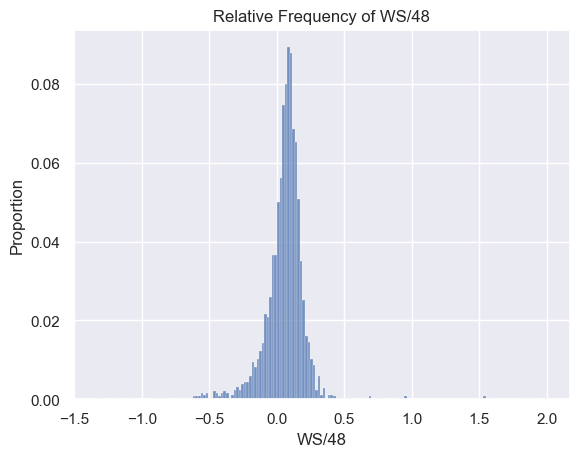

In [13]:
sns.set()

#Plot out WS/48 via histogram
sns.histplot(data=final_df, x='WS/48', stat='proportion').set(title='Relative Frequency of WS/48')

Wins Share per game visually looks normally distributed, which is ideal given that I'll utilize linear regression later. Let's confirm this view with descriptive statistics.

In [14]:
#Look at descriptive stats for 'WS/48'
print(final_df['WS/48'].describe())
print(stats.skew(final_df['WS/48']))
print(stats.kurtosis(final_df['WS/48']))

count    2543.000000
mean        0.059161
std         0.176054
min        -1.339000
25%         0.004000
50%         0.075000
75%         0.133000
max         2.002000
Name: WS/48, dtype: float64
1.1156495775815163
28.89097247141527


The descriptive statistics show that WS/48 is close to being normally distributed, although there are still higher moments (positive skew and extremely positive kurtosis) to consider. I'm also curious about how this feature looks for different positions on the court. Time to view more histograms!

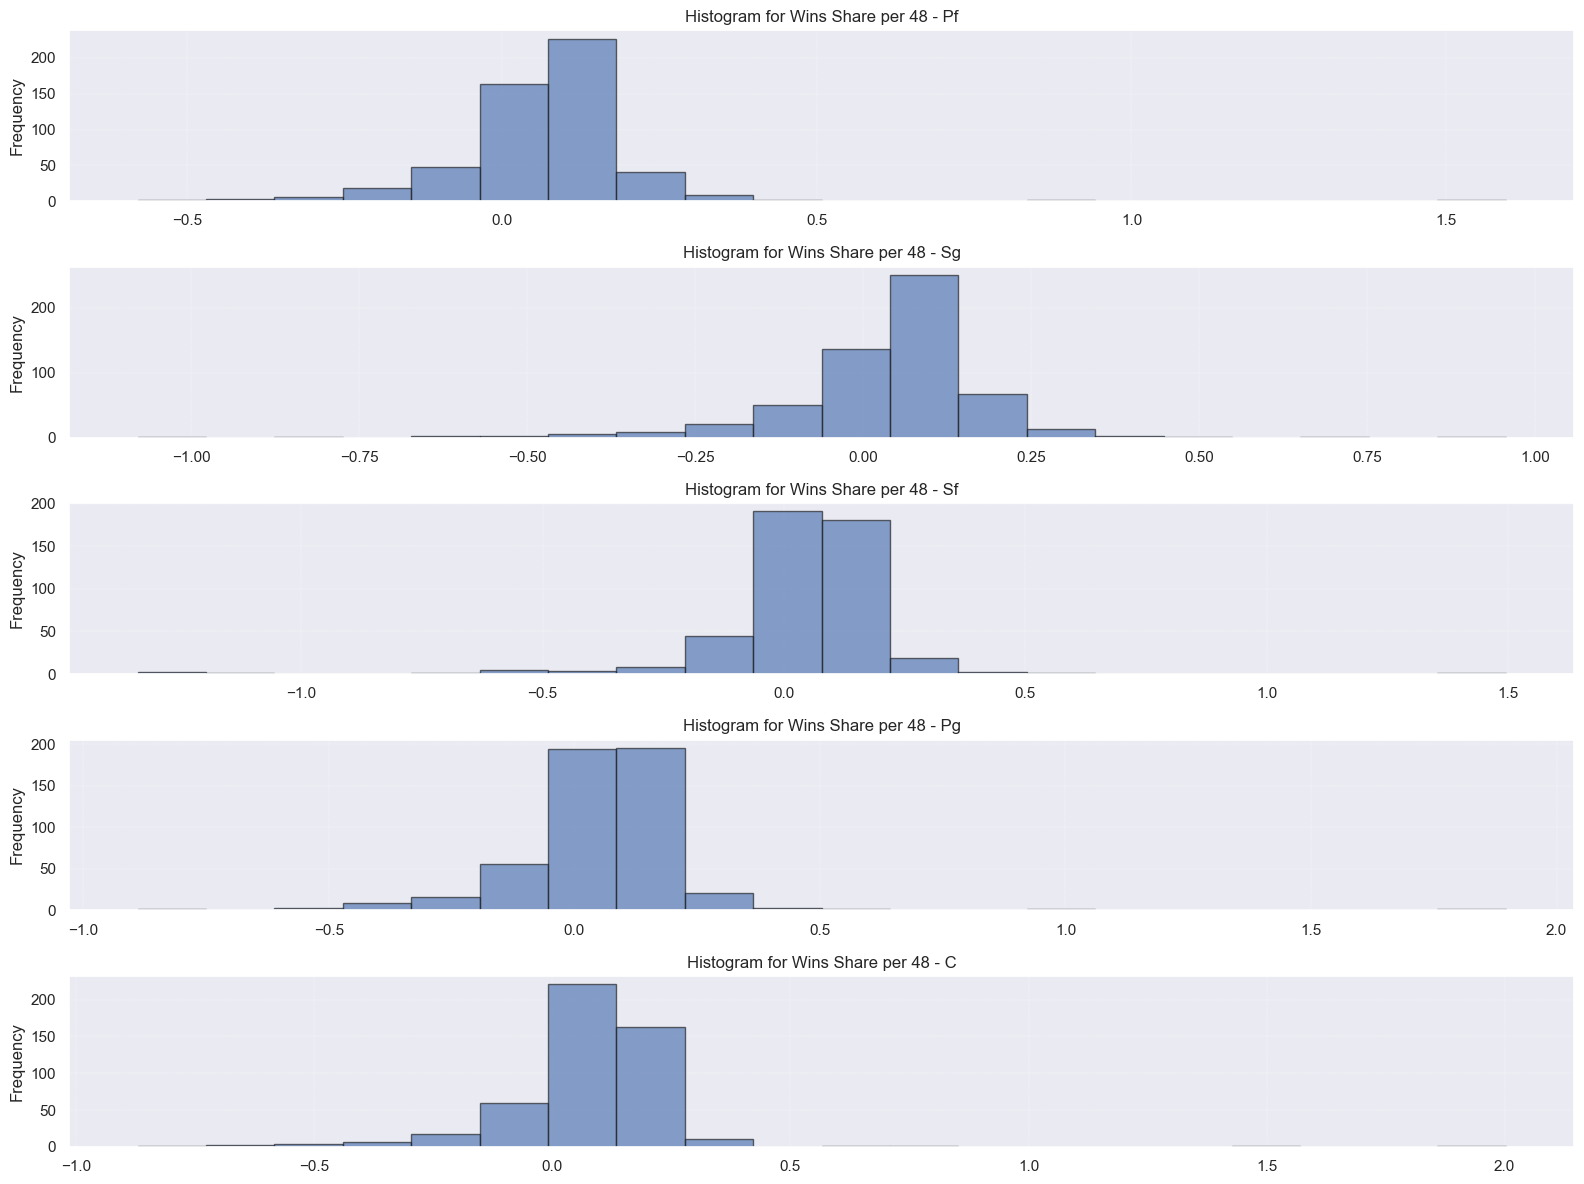

In [15]:
# Unique positions in the dataset
pos_list = final_df['Pos'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=len(pos_list), ncols=1, figsize=(16, 12))

for idx, pos in enumerate(pos_list):
    subset = final_df[final_df['Pos'] == pos]
    axes[idx].hist(subset['WS/48'], bins=20, edgecolor='k', alpha=0.65)
    axes[idx].set_title(f"Histogram for Wins Share per 48 - {pos.capitalize()}")
    axes[idx].set_ylabel("Frequency")
    axes[idx].grid(True, which='both', linestyle='--', linewidth=0.25)

# Adjust layout
plt.tight_layout()
plt.show()


The WS/48 for each position tends to fall within the 0.0-0.3 range, with a few significant outliers to the positive. The only position this doesn't hold for is shooting guards (SG), which I've always viewed as the position least likely to contribute to winning based on the role of most shooting guards (i.e., primary focus on scoring alone) within a team structure. The high kurtosis is coming from outliers happening more than expected, which I will correct for later.

One area I want to dive deeper into is how minutes per game (MPG) influence wins per 48. I will create a categorical variable for players who play "starter" minutes, are "in the rotation," and barely get on the court. But first, let's create a feature to track MPG in the first place.

[Text(0.5, 1.0, 'Freq. of MPG')]

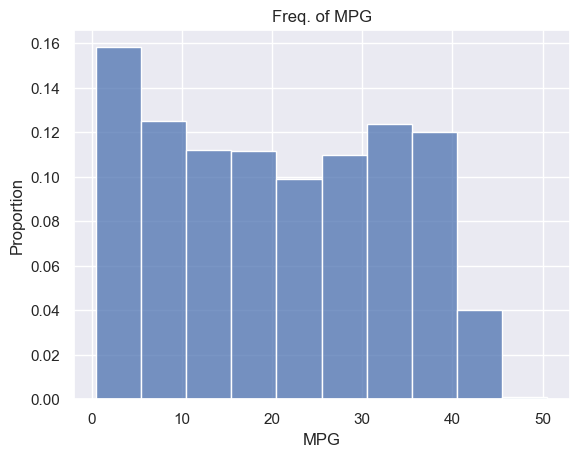

In [16]:
#create a new feature for minutes played per game
final_df['MPG'] = final_df['MP'] / final_df['G']

sns.histplot(data=final_df, x='MPG', stat='proportion',binwidth=5).set(title='Freq. of MPG')

In [17]:
#creaate a new feature to categorize MPG
final_df['rotation_status']=pd.cut(final_df['MPG'], bins=[0,8,25,50], labels=['GT','bench', 'starter'])

final_df['rotation_status'].value_counts(normalize=True)

starter    0.401101
bench      0.374754
GT         0.224145
Name: rotation_status, dtype: float64

Given that non-GT (or garbage time) players disproportionally make up the number of observations relative to their production, I will revisit the distribution of wins per 48 without the GT players.

In [18]:
r_df = final_df[final_df['rotation_status']!='GT']

print(r_df['WS/48'].describe())
print(stats.skew(r_df['WS/48']))
print(stats.kurtosis(r_df['WS/48']))

count    1973.000000
mean        0.074604
std         0.089408
min        -0.544000
25%         0.027000
50%         0.080000
75%         0.131000
max         0.631000
Name: WS/48, dtype: float64
-0.48076112956811135
2.7920769852313603


Although the distribution for the non-GT players is closer to normal, there are still higher moments (mainly positive kurtosis) that I would like to further account for. I'll see if winsorization or setting absolute values (maximum or minimum) would be a better approach to handling the higher moments.

In [19]:
#testing the use winsorizing WS/48
winsorized = winsorize(final_df['WS/48'], (0.05,0.05))

#Viewing the descreptive statistics
print(np.mean(winsorized))
print(np.median(winsorized))
print(np.std(winsorized))
print(stats.skew(winsorized))
print(stats.kurtosis(winsorized))

0.060327959103421154
0.075
0.10659924267080735
-0.5882196791439751
-0.09651853387160214


C:\Users\mikei\anaconda3\envs\nba_roster\lib\site-packages\numpy\core\fromnumeric.py:755: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [20]:
#testing by setting the minimum and maximum value of WS/48
new_test = final_df['WS/48']
new_test = new_test.apply( lambda x: 0.65 if x>=0.65 else x)
new_test = new_test.apply( lambda x: -0.65 if x<=-0.65 else x)

#Viewing the descreptive statistics
print(np.mean(new_test))
print(np.median(new_test))
print(np.std(new_test))
print(stats.skew(new_test))
print(stats.kurtosis(new_test))

0.0569823043649232
0.075
0.1458496877646187
-0.9890398857503806
5.62254237338046


Winsorizing led to a better distribution, so I'll use this method. I'll also see how WS/48 looks by position to see where the outliers (if any) exist.

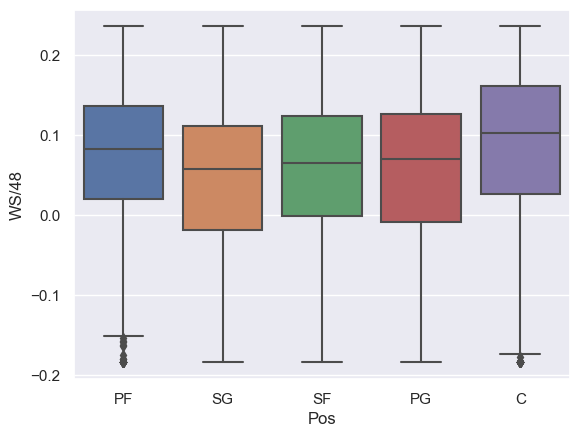

In [21]:
#winsorizing WS/48 to the 5% level for both tails
final_df['WS/48'] = winsorize(final_df['WS/48'], (0.05,0.05))

#visualizing WS/48 by position
sns.boxplot(data=final_df, x='Pos', y='WS/48')
plt.show()

These results look promising! Let's also view the same feature while parsing out the rotation status of the various players.

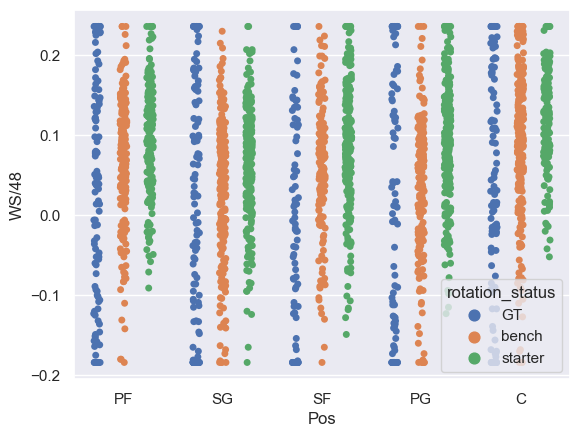

In [22]:
#visualizing WS/48 by both position and rotation status
sns.stripplot(data=final_df, x='Pos', y='WS/48', hue='rotation_status', dodge=True)
plt.show()

Looking at the strip plot above, I’m most surprised by the distribution in garbage time (GT) WS/48. I would expect more of a cluster near zero, as these players don’t have enough time on the court to make a significant impact. 

One of the beliefs I have for championship-caliber teams is that they should be able to win about two-thirds of their games in the regular season and the playoffs. This standard would lead to at least ~53 wins in the regular season and winning a playoff series in six games (4-2). Winning that many games in the regular season is typically enough to get good playoff seeding while not over-extending star players during an 82-game season. Based on this belief, I’ll reshape the WS/48 target feature to reflect the win percentage for a 65% win rate. I will also minimize the impact of GT player’s contribution to winning.


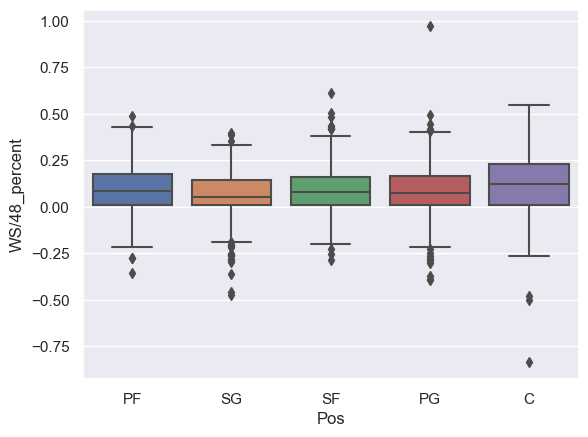

In [23]:
#Creating a new feature based on desired winning percentage
final_df['WS/48_percent'] = r_df['WS/48'] / 0.65
final_df['WS/48_percent'] = final_df['WS/48_percent'].fillna(0.01)

#Viewing the new feature by position
sns.boxplot(data=final_df, x='Pos', y='WS/48_percent')
plt.show()

Although there are more outliers in the data, I attribute that to minimizing the impact of GT’s win production. Seeing the most substantial negative outliers at the Center position is also surprising. I hope those players never played for my Lakers!

Another change I want to make is to the salary cap. First, I want to expand the salary cap, as most playoff teams tend to have payrolls that are 20-40% higher than the salary cap for any given year. I also want to compare a player’s salary to the expanded salary cap. This desire will lead to a new feature (cap_percent) to compare to a player’s percentage of the desired winning percentage (WS/48_percent). If a player’s production percentage is higher than the salary cap percentage, then a team would have found “value” in that player.


In [24]:
#New features for expanded salary cap and salary cap percentage
final_df['expanded_salary_cap'] = final_df['Salary Cap'] * 1.25
final_df['cap_percent'] = final_df['salary'] / final_df['expanded_salary_cap']

#Viewing the impact of expanded salary cap based on rotation status and position 
final_df.groupby(['Pos','rotation_status'])['cap_percent'].median()

Pos  rotation_status
C    GT                 0.013224
     bench              0.039360
     starter            0.141359
PF   GT                 0.013298
     bench              0.033143
     starter            0.118581
PG   GT                 0.012555
     bench              0.021773
     starter            0.080325
SF   GT                 0.012133
     bench              0.024844
     starter            0.084479
SG   GT                 0.012473
     bench              0.027132
     starter            0.069135
Name: cap_percent, dtype: float64

It looks like Centers and Power Forwards cost the most to acquire when based on the median value. I attribute part of this to fewer people in the world being tall enough (usually 6 foot 9 inches and above) to play those positions. This result also leads to one of the aspects I want to test: the influence of positional value later on.

Another area where I think taller players can provide more value (or “perceived value”) is on the defensive end. This view also supports another hypothesis I have for this project: championship-caliber teams tend to have players who are not liabilities on either end (offensive or defensive) of the court.

I’ll start exploring this hypothesis by creating features related to contributing or detracting on offense or defense. I’ll start by calculating how much of a player’s value comes from the defense using the defensive plus/minus statistic.

In [25]:
#Creading a defensive value add feature for non-GT players
final_df['def_add'] = r_df['DBPM'] / r_df['BPM']

#Having all GT player's defensive value add be zero
final_df['def_add'] = final_df['def_add'].fillna(0)

#Viewing the median and values by positions and rotation status, as well as viewing the feature's distribution
print(final_df.groupby(['Pos','rotation_status'])['def_add'].median())
print(final_df['def_add'].describe())

Pos  rotation_status
C    GT                 0.000000
     bench              0.200000
     starter            0.437500
PF   GT                 0.000000
     bench              0.250000
     starter            0.317073
PG   GT                 0.000000
     bench              0.297335
     starter            0.223979
SF   GT                 0.000000
     bench              0.250000
     starter            0.323529
SG   GT                 0.000000
     bench              0.252119
     starter            0.250000
Name: def_add, dtype: float64
count    2543.000000
mean             NaN
std              NaN
min             -inf
25%         0.000000
50%         0.102564
75%         0.500000
max              inf
Name: def_add, dtype: float64


My initial view that Centers and Power Forwards have more impact on the defensive end is holding up, especially for starting players. The distribution is a little wonky though, as some player’s value may come entirely from the defensive end. I’ll adjust the distribution later on in the project.

Using the plus/minus statistics, I’ll create categorical features to represent whether a player is an asset or a liability on both sides of the court. Since I’m more focused on liability, I’ll create a feature for this first.

In [26]:
#Creating a defensive liability categorical feature for non-GT players
final_df['def_liab'] = r_df['DBPM'].apply( lambda x: 'Yes' if x<= 0 else 'No')

#Marking all GT players not being defensive liabilities
final_df['def_liab'] = final_df['def_liab'].fillna('No')

#Creating the same feature, but for offensive liability
final_df['off_liab'] = r_df['OBPM'].apply( lambda x: 'Yes' if x<= 0 else 'No')
final_df['off_liab'] = final_df['off_liab'].fillna('No')

#Viewing the count of each feature in a normalized fashion
print(final_df['def_liab'].value_counts(normalize=True))
print(final_df['off_liab'].value_counts(normalize=True))

No     0.683052
Yes    0.316948
Name: def_liab, dtype: float64
No     0.56626
Yes    0.43374
Name: off_liab, dtype: float64


Surprisingly, more players were offensive liabilities than defensive liabilities. My initial thought is that rotational status plays a role here. I’ll test that view below.

In [27]:
#Viewing offensive and defensive liability features by rotational status
print(final_df.groupby(['rotation_status'])['def_liab'].value_counts(normalize=True))
print(final_df.groupby(['rotation_status'])['off_liab'].value_counts(normalize=True))

rotation_status  def_liab
GT               No          1.000000
bench            No          0.577125
                 Yes         0.422875
starter          No          0.604902
                 Yes         0.395098
Name: def_liab, dtype: float64
rotation_status  off_liab
GT               No          1.000000
bench            Yes         0.734523
                 No          0.265477
starter          No          0.604902
                 Yes         0.395098
Name: off_liab, dtype: float64


My initial inclination was correct, as the difference between the starters and bench players is that bench players are likelier not to have the consistent offensive skills to stay on the court. It also speaks to bench players needing a different skill set than starters on a team. 

I’ll now focus on creating categorical features for “asset” players on the court. What’s more interesting to me are the players that are “assets” on both ends of the floor and star players (based on a higher usage rate and rotational status) that I would consider an asset. Just like liabilities can have a non-linear negative influence on wins, I believe “star assets” have a non-linear positive influence on winning.

In [28]:
#Creating the defensive asset categorical feature
final_df['def_asset'] = r_df['DBPM'].apply( lambda x: 'Yes' if x>= 1 else 'No')
final_df['def_asset'] = final_df['def_asset'].fillna('No')

#Creating the offensive asset categorical feature
final_df['off_asset'] = r_df['OBPM'].apply( lambda x: 'Yes' if x>= 1 else 'No')
final_df['off_asset'] = final_df['off_asset'].fillna('No')

#Creating the total asset categorical feature
def asset(row):
    if row['def_asset'] == 'Yes' and row['off_asset'] == 'Yes':
        val = 'Yes'
    else:
        val = 'No'
    return val

final_df['total_asset'] = final_df.apply(asset, axis=1)

#Creating the star asset categorical feature
def star(row):
    if row['USG%'] >= 25 and row['rotation_status'] == 'starter':
        if row['def_liab'] == 'No' and row['off_asset'] == 'Yes':
            val = 'Yes'
        else:
            val = 'No'
    else:
        val = 'No'
    return val

final_df['star_asset'] = final_df.apply(star, axis=1)

#Viewing the normalized count of features created
print(final_df['def_asset'].value_counts(normalize=True))
print(final_df['off_asset'].value_counts(normalize=True))
print(final_df['total_asset'].value_counts(normalize=True))
print(final_df['star_asset'].value_counts(normalize=True))

No     0.71805
Yes    0.28195
Name: def_asset, dtype: float64
No     0.754227
Yes    0.245773
Name: off_asset, dtype: float64
No     0.880456
Yes    0.119544
Name: total_asset, dtype: float64
No     0.955564
Yes    0.044436
Name: star_asset, dtype: float64


Overall, there aren’t many “star assets” in the NBA. Based on the figure above, I calculate an average of 7-8 star asset players a season.	

Now that we have the asset and liability categorical features out of the way, I will create the last categorical feature based on a player’s age. There’s been a lot of work on when a player’s production peaks (around 24-25 years old), while the NBA’s Collective Bargaining Agreement (CBA) increases the veteran’s minimum the longer a player is in the NBA. Before creating the feature, I will see where I should place boundaries regarding a player’s increasing and decreasing production value. 

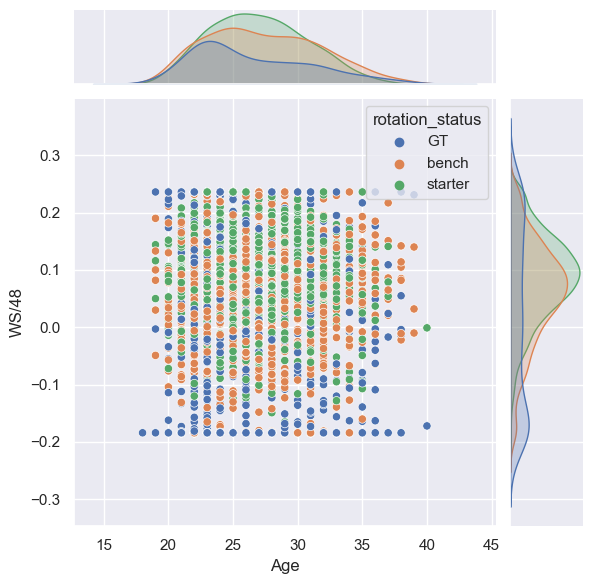

In [29]:
#Graph the wins production by age and rotational status
sns.jointplot(x='Age', y='WS/48', data=final_df, hue='rotation_status')
plt.show()

Based on the information in the graph above, I’ll mark a player’s ‘prime’ for wins production between the ages of 24 and 30.

In [30]:
#Creating the prime status categorical feature
final_df['prime_status']=pd.cut(final_df['Age'], bins=[17,24,30,50], labels=['Ascending','Prime', 'Descending'])

#Viewing the normalized count of the new feature
final_df['prime_status'].value_counts(normalize=True)

Prime         0.455761
Ascending     0.324813
Descending    0.219426
Name: prime_status, dtype: float64

I’ll now look at the distribution of the other numerical features used in this project to understand the underlying characteristics better. 

In [31]:
#Viewing the distribution and skew of numerical features.
print(final_df[['TS%', '3PAr', 'FTr','ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'def_add']].describe())
print(final_df[['TS%', '3PAr', 'FTr','ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'def_add']].skew())

               TS%         3PAr          FTr         ORB%         DRB%  \
count  2543.000000  2543.000000  2543.000000  2543.000000  2543.000000   
mean      0.509737     0.288468     0.312681     5.404326    14.781361   
std       0.172109     0.251379     0.338418     6.332441     8.384725   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.450000     0.012000     0.133000     1.400000     9.300000   
50%       0.521000     0.286000     0.250000     3.700000    13.700000   
75%       0.583000     0.465500     0.394000     7.750000    19.150000   
max       1.500000     1.000000     4.000000   100.000000    63.100000   

              TRB%         AST%         STL%         BLK%         TOV%  \
count  2543.000000  2543.000000  2543.000000  2543.000000  2543.000000   
mean     10.046481    11.957059     1.465474     1.577546    12.277664   
std       5.837677    11.450426     1.508300     2.134438     8.613107   
min       0.000000     0.000000     0

There are a lot of positive outliers in these features, plus the defensive add feature still looks weird. Given the heavy reliance on linear regression, I’ll winsorize the data for 90% of observed values utilized. The winsorization will allow for some outliers to persist without them having too much of an influence on the regression results. I’ll also reset the minimum value for the features to a percentage near zero (0.0001). The code for this section is another area where ChatGPT was extremely helpful.

In [32]:
#Creating a user-defined function for winsorizing multiple features
def winsorize_df(df, columns, limits):
    df_copy = df.copy() # To avoid changing the original DataFrame
    for column in columns:
        if column in df.columns:
            df_copy[column] = winsorize(df_copy[column], limits=limits)
        else:
            print(f"Column {column} does not exist in the DataFrame.")
    return df_copy

#Creating a user-defined function for replacing values for multiple features based on a minimum value
def replace_values(df, columns, threshold, new_value):
    df_copy = df.copy() # To avoid changing the original DataFrame
    for column in columns:
        if column in df.columns:
            df_copy[column] = df_copy[column].where(df_copy[column] >= threshold, new_value)
        else:
            print(f"Column {column} does not exist in the DataFrame.")
    return df_copy

#Applying both functions to the numerical features
final_df = winsorize_df(final_df, ['TS%', '3PAr', 'FTr','ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%','def_add'], (0.05, 0.05))
final_df = replace_values(final_df, ['TS%', '3PAr', 'FTr','ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%','def_add'], 0.0001, 0.0001)
print(final_df[['TS%', '3PAr', 'FTr','ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'def_add']].describe())
print(final_df[['TS%', '3PAr', 'FTr','ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'def_add']].skew())

               TS%         3PAr          FTr         ORB%         DRB%  \
count  2543.000000  2543.000000  2543.000000  2543.000000  2543.000000   
mean      0.508603     0.281588     0.284549     5.015116    14.527487   
std       0.124887     0.235945     0.221372     4.568639     7.125947   
min       0.198000     0.000100     0.000100     0.000100     2.300000   
25%       0.450000     0.012000     0.133000     1.400000     9.300000   
50%       0.521000     0.286000     0.250000     3.700000    13.700000   
75%       0.583000     0.465500     0.394000     7.750000    19.150000   
max       0.734000     0.720000     0.833000    15.400000    29.400000   

              TRB%         AST%         STL%         BLK%         TOV%  \
count  2543.000000  2543.000000  2543.000000  2543.000000  2543.000000   
mean      9.902517    11.369459     1.352909     1.460158    11.753571   
std       4.915508     9.434926     1.030152     1.696052     7.046176   
min       2.600000     0.000100     0

The distribution of these features is better suited for linear regression analysis. I will also add more features related to a “risk/reward” view for player statistics. An example of this type of statistic is the assist-to-turnover ratio.

In [33]:
#Creating a feature for assist-to-turnover ratio
final_df['AST/TOV'] = r_df['AST%'] / r_df['TOV%']
final_df['AST/TOV'] = final_df['AST/TOV'].fillna(0.0001)

#Creating a feature for turnover rate per usage rate
final_df['TOV_per_USG'] = r_df['TOV%'] / (r_df['USG%'])
final_df['TOV_per_USG'] = final_df['TOV_per_USG'].fillna(0.0001)

#Creating a feature for three point rate-to-true shooting percentage ratio
final_df['Three_Pt_to_TS'] = r_df['3PAr'] / (r_df['TS%'])
final_df['Three_Pt_to_TS'] = final_df['Three_Pt_to_TS'].fillna(0.0001)

#Creating a feature for free throw rate-to-true shooting percentage ratio
final_df['FT_to_TS'] = r_df['FTr'] / (r_df['TS%'])
final_df['FT_to_TS'] = final_df['FT_to_TS'].fillna(0.0001)

#Applying both functions to new features
final_df = winsorize_df(final_df,['AST/TOV', 'TOV_per_USG', 'Three_Pt_to_TS', 'FT_to_TS'], (0.05,0.05))
final_df = replace_values(final_df,['AST/TOV', 'TOV_per_USG', 'Three_Pt_to_TS', 'FT_to_TS'], 0.0001, 0.0001)

#Viewing the distribution of new features
print(final_df[['AST/TOV', 'TOV_per_USG', 'Three_Pt_to_TS', 'FT_to_TS']].describe())

           AST/TOV  TOV_per_USG  Three_Pt_to_TS     FT_to_TS
count  2543.000000  2543.000000     2543.000000  2543.000000
mean      0.873816     0.562865        0.425897     0.428089
std       0.869300     0.469471        0.439785     0.360945
min       0.000100     0.000100        0.000100     0.000100
25%       0.011830     0.154599        0.000100     0.000100
50%       0.666667     0.512077        0.337580     0.407960
75%       1.330158     0.821769        0.779861     0.657676
max       3.014706     1.644444        1.312073     1.214575


I now have all of the features I wanted to use for this project. I’ll review all of the features and remove the ones that will not be useful from this point forward.

In [34]:
#View all of the features
final_df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'MP', 'PER', 'TS%', '3PAr', 'FTr',
       'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS',
       'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP', 'Season', 'team',
       'salary', 'Salary Cap', '2022 Salary Cap Adj.', 'MPG',
       'rotation_status', 'WS/48_percent', 'expanded_salary_cap',
       'cap_percent', 'def_add', 'def_liab', 'off_liab', 'def_asset',
       'off_asset', 'total_asset', 'star_asset', 'prime_status', 'AST/TOV',
       'TOV_per_USG', 'Three_Pt_to_TS', 'FT_to_TS'],
      dtype='object')

In [35]:
#Remove all of the featues that are repetitive or not used going forward
final_df.drop(['Tm', 'PER', 'OWS', 'DWS', 'WS', 'BPM', 'VORP'], axis=1, inplace=True)
df = final_df.copy()

df.columns

Index(['Player', 'Pos', 'Age', 'G', 'MP', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%',
       'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'WS/48', 'OBPM', 'DBPM',
       'Season', 'team', 'salary', 'Salary Cap', '2022 Salary Cap Adj.', 'MPG',
       'rotation_status', 'WS/48_percent', 'expanded_salary_cap',
       'cap_percent', 'def_add', 'def_liab', 'off_liab', 'def_asset',
       'off_asset', 'total_asset', 'star_asset', 'prime_status', 'AST/TOV',
       'TOV_per_USG', 'Three_Pt_to_TS', 'FT_to_TS'],
      dtype='object')

In [36]:
#Review all of the numerical features
df.describe()

,Age,G,MP,TS%,3PAr,FTr,ORB%,DRB%,TRB%,AST%,...,2022 Salary Cap Adj.,MPG,WS/48_percent,expanded_salary_cap,cap_percent,def_add,AST/TOV,TOV_per_USG,Three_Pt_to_TS,FT_to_TS
count,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000,...,2.543000e+03,2543.000000,2543.000000,2.543000e+03,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000,2543.000000
mean,27.011011,8.590248,197.257963,0.508603,0.281588,0.284549,5.015116,14.527487,9.902517,11.369459,...,8.758643e+07,20.636410,0.091290,8.789881e+07,0.064087,0.361543,0.873816,0.562865,0.425897,0.428089
std,4.172127,5.666410,190.169406,0.124887,0.235945,0.221372,4.568639,7.125947,4.915508,9.434926,...,1.857953e+07,12.511005,0.128792,2.462467e+07,0.065038,0.542417,0.869300,0.469471,0.439785,0.360945
min,18.000000,1.000000,1.000000,0.198000,0.000100,0.000100,0.000100,2.300000,2.600000,0.000100,...,7.183955e+07,0.500000,-0.836923,6.187500e+07,0.000037,0.000100,0.000100,0.000100,0.000100,0.000100
25%,24.000000,4.000000,50.000000,0.450000,0.012000,0.133000,1.400000,9.300000,5.900000,4.300000,...,7.397055e+07,9.045455,0.010000,7.255500e+07,0.014040,0.000100,0.011830,0.154599,0.000100,0.000100
50%,27.000000,6.000000,144.000000,0.521000,0.286000,0.250000,3.700000,13.700000,9.100000,8.800000,...,7.741468e+07,20.125000,0.080000,7.334875e+07,0.039898,0.102564,0.666667,0.512077,0.337580,0.407960
75%,30.000000,12.000000,270.000000,0.583000,0.465500,0.394000,7.750000,19.150000,13.300000,16.800000,...,1.123683e+08,32.000000,0.173846,1.176788e+08,0.091486,0.500000,1.330158,0.821769,0.779861,0.657676
max,40.000000,26.000000,986.000000,0.734000,0.720000,0.833000,15.400000,29.400000,20.200000,33.500000,...,1.233842e+08,47.333333,0.970769,1.364250e+08,0.319113,2.000000,3.014706,1.644444,1.312073,1.214575


# Part 1 – Finding Market Inefficiencies between Wins Production and Salaries

This section aims to understand better which independent features have a linear relationship to the target features (win percent and salary cap percent) and see where there are disconnects between the two target features. 

I’ll start this section with a correlation matrix heatmap while utilizing the assistance of ChatGPT.

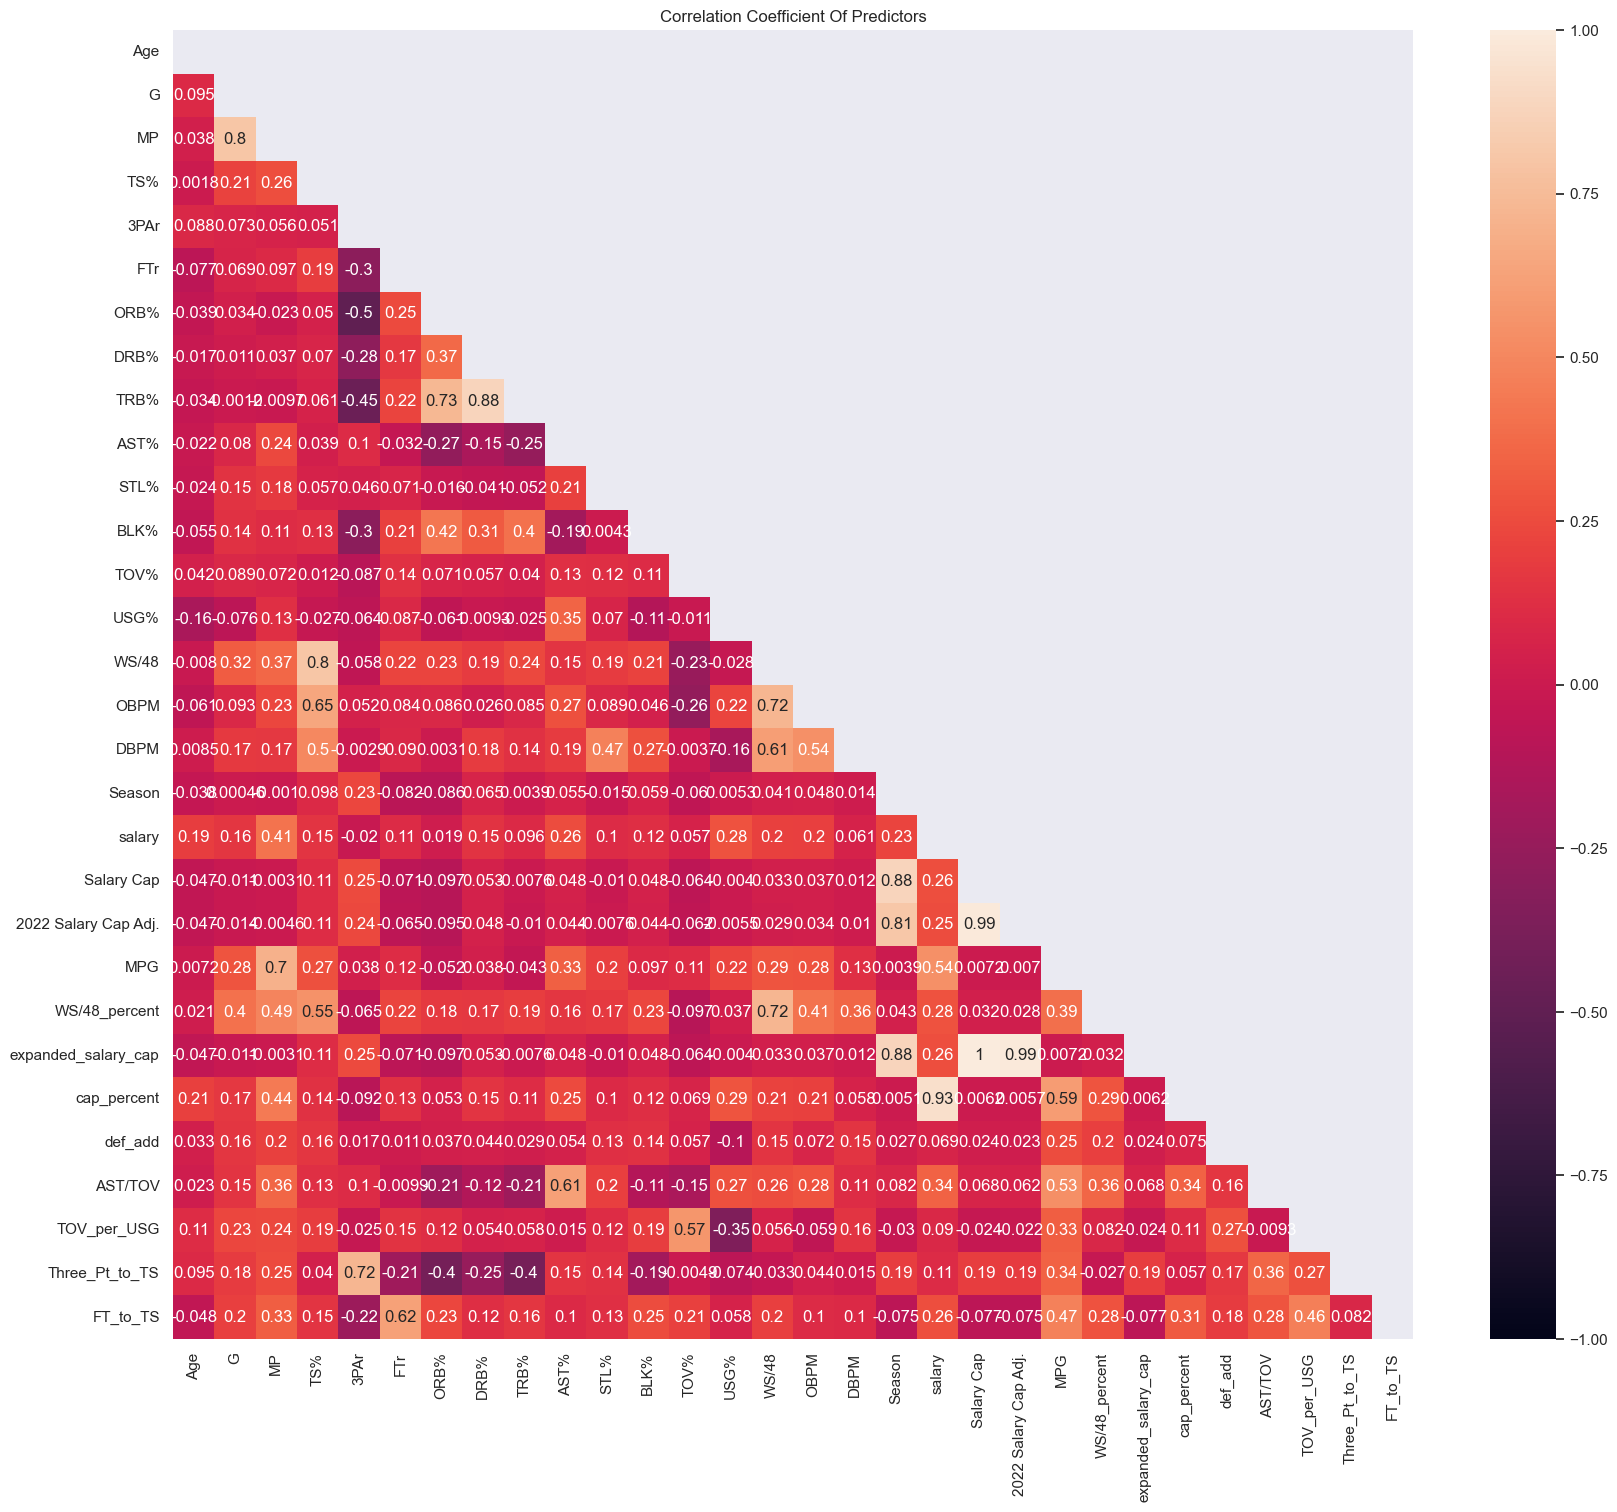

In [37]:
#Set figure size
plt.figure(figsize=(20,17))

#Generate a mask to onlyshow the bottom triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

#Generate heatmap
sns.heatmap(df.corr(), annot=True, mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Coefficient Of Predictors')
plt.show()


The most significant observations I make from the correlation matrix heatmap are 1) true shooting percentage (TS%) has the most immense impact on win percentage out of the advanced metrics I’m comparing, 2) minutes per game (MPG) plays a significant role in both win percent and salary cap percent, and 3) there is almost zero correlation between win percent and salary cap percent. I will now conduct a variance inflation factor (VIF) analysis to see if multicollinearity exists in the data, focusing on different rebounding, assist, and shooting efficiency measures.

In [38]:
#Compute the VIF for all given features
def compute_vif(considered_features):
    
    X = df[considered_features]
    #The calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    #Create dataframe to store VIF values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

#The features to consider removing
considered_features = ['ORB%', 'DRB%', 'TRB%', 'AST%', 'AST/TOV', 'TOV%', 'Three_Pt_to_TS', '3PAr', 'MPG']


#Compute VIF 
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\mikei\AppData\Local\Temp\ipykernel_24276\3404585744.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
2,TRB%,28.342603
1,DRB%,15.363012
0,ORB%,7.318420
6,Three_Pt_to_TS,3.043334
7,3PAr,2.802630
4,AST/TOV,2.622711
3,AST%,1.962076
8,MPG,1.649507
5,TOV%,1.263470


The ideal situation is to have the VIFs of the independent features in question be less than 5. Unfortunately, all three rebounding measures are above this figure. However, I do believe that being good at rebounding on one end of the floor doesn’t fully translate to the other end. The VIFs also point this out, with total rebounding (TRB) having the highest score. I’ll see how the scores change if I remove the TRB feature.

In [39]:
#Removing TRB feature
considered_features.remove('TRB%')

#New VIFs
compute_vif(considered_features).sort_values('VIF', ascending=False)

C:\Users\mikei\AppData\Local\Temp\ipykernel_24276\3404585744.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1


,Variable,VIF
5,Three_Pt_to_TS,3.036453
6,3PAr,2.799930
3,AST/TOV,2.602463
2,AST%,1.959379
7,MPG,1.630060
0,ORB%,1.534663
4,TOV%,1.228587
1,DRB%,1.204929


The VIF scores are much lower after removing the TRB feature, so I’ll exclude it for the rest of the statistical analysis. I will run a series of linear regressions for both win and salary cap percentages as the target features. I’ll start with one regression for each that considers all of the advanced metrics of interest with the categorical features. I'll also leave out the rotation status feature, as this information is captured in minutes per game.

Before running the regression, I’ll list a few hypotheses I have about win percentage as the target feature:

1. Based on playing thousands of pickup games and watching the NBA playoffs, I believe that the team that has the fewest weaknesses (combined with a go-to scoring threat) tends to be the best team. Based on this view, the offensive and defensive liability categorical features would be statistically significant features.


2. Although true shooting percentage is important, it’s more important based on the makeup of shots a player takes. This is especially important regarding a player’s free throw rate, as free throws are both a positive for the offense and a foul for the defense. Austin Reaves’s game for the LA Lakers is a perfect example of this, as his ability to get to the free throw line plays a significant role in him being a positive contributor to winning while being the third option on a playoff team. The free throw rate to true shooting percentage ratio (FT_to_TS) would be statistically significant and positive if correct.


3. Although assists are essential at the team level, I don’t think they’re that important on an individual player level. What’s more important is the turnover rate for a player relative to their usage rate. This is why I think players like Trae Young, Lemalo Ball, and the New York Knicks version of Jeremy Lin were all overrated, as they had high usage rates to go along with their turnovers. If correct, the assist rate would be statistically insignificant, while the turnover rate to usage rate ratio (TOV_per_USG) would be statistically significant.


4. From Lebron James, to Larry Bird, to Jayson Tatum, to Jimmy Butler, I view Small Forward as the most important position on the court. This is the only position that can guard all five positions and bring the ball up the floor to initiate offense from a conventional sense. Based on the EDA, this also gives me the view that the Shooting Guard position may also be overrated. If correct, a player would be a statistically significant contributor as a Small Forward while being a statistically significant detractor as a Shooting Guard.



In [40]:
#Copy dataframe and rename a few features so they're compatible with the StatsModel package
df_smf = df.copy()
df_smf.columns = df_smf.columns.str.replace("%", "")
df_smf.columns = df_smf.columns.str.replace("3PAr", "Three_PAr")
df_smf.columns = df_smf.columns.str.replace("WS/48_percent", "win_percent")

#Set up the linear regression equations for both target features 
win_percent_full = 'win_percent ~ C(Pos) + C(def_liab) + C(off_liab) + C(def_asset) + C(off_asset) + C(total_asset) + C(star_asset) + C(prime_status) + Age + TS + Three_PAr + FTr + ORB + DRB + AST + STL + BLK + TOV + USG + MPG + def_add + AST/TOV + TOV_per_USG + FT_to_TS + Three_Pt_to_TS'
cap_percent_full = 'cap_percent ~ C(Pos) + C(def_liab) + C(off_liab) + C(def_asset) + C(off_asset) + C(total_asset) + C(star_asset) + C(prime_status) + Age + TS + Three_PAr + FTr + ORB + DRB + AST + STL + BLK + TOV + USG + MPG + def_add + AST/TOV + TOV_per_USG + FT_to_TS + Three_Pt_to_TS'

#Fit the regression inputs to win percentage and show the results
win_est_1 = smf.ols(formula= win_percent_full, data=df_smf).fit()
win_est_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            win_percent   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     166.8
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:20:32   Log-Likelihood:                 2968.6
No. Observations:                2543   AIC:                            -5877.
Df Residuals:                    2513   BIC:                            -5702.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.1175      0.025     -4.788      0.000      -0.166      -0.069
C(Pos)[T.PF]                     -0.0040      0.005     -0.762      0.446      -0.014       0.006
C(Pos)[T.PG]                      0.0059      0.007      0.784      0.433      -0.009       0.020
C(Pos)[T.SF]                     -0.0077      0.006     -1.209      0.227      -0.020       0.005
C(Pos)[T.SG]                     -0.0127      0.007     -1.903      0.057      -0.026       0.000
C(def_liab)[T.Yes]               -0.0424      0.005     -9.419      0.000      -0.051      -0.034
C(off_liab)[T.Yes]               -0.0226      0.005     -4.335      0.000      -0.033      -0.012
C(def_asset)[T.Yes]               0.0580      0.006      9.957      0.000       0.047       0.069
C(off_asset)[T.Yes]               0.0886      0.006     13.659      0.000       0.076       0.101
C(total_asset)[T.Yes]            -0.0117      0.008     -1.512      0.131      -0.027       0.003
C(star_asset)[T.Yes]              0.0550      0.009      6.239      0.000       0.038       0.072
C(prime_status)[T.Prime]         -0.0017      0.006     -0.299      0.765      -0.013       0.009
C(prime_status)[T.Descending]    -0.0012      0.011     -0.111      0.911      -0.022       0.019
Age                               0.0012      0.001      1.278      0.201      -0.001       0.003
TS                                0.3159      0.014     22.476      0.000       0.288       0.343
Three_PAr                         0.0221      0.012      1.900      0.057      -0.001       0.045
FTr                               0.0011      0.010      0.112      0.911      -0.018       0.021
ORB                               0.0034      0.000      7.467      0.000       0.003       0.004
DRB                            9.247e-05      0.000      0.366      0.714      -0.000       0.001
AST                               0.0006      0.000      1.788      0.074   -5.72e-05       0.001
STL                              -0.0010      0.002     -0.624      0.533      -0.004       0.002
BLK                              -0.0008      0.001     -0.685      0.494      -0.003       0.001
TOV                              -0.0015      0.000     -4.223      0.000      -0.002      -0.001
USG                              -0.0022      0.000     -6.468      0.000      -0.003      -0.002
MPG                               0.0015      0.000      8.247      0.000       0.001       0.002
def_add                           0.0193      0.003      5.800      0.000       0.013       0.026
AST:TOV                       -4.963e-05   2.16e-05     -2.303      0.021   -9.19e-05   -7.37e-06
TOV_per_USG                      -0.0158      0.006     -2.533      0.011      -0.028      -0.004
FT_to_TS                          0.0414     

Based on the first regression, the true shooting percentage (TS) is the most significant feature for determining a player’s win contribution based on the t-statistic. Based on the initial correlation matrix, I saw this coming, but it’s also nice that most of my hypotheses were correct. Both liability features were negative and statistically significant, the free throw rate relative to true shooting percentage matters more than the free throw rate alone, the assist rate is statistically insignificant while the turnover per usage rate is significant, and the Shooting Guard position is a negative contributor to winning. The only hypothesis I was incorrect on was the value of the Small Forward position.

Other prominent features include offensive asset, defensive liability, defensive asset, minutes per game (MPG), and offensive rebounding percentage (ORB). Other interesting observations from this regression are 1) a player being an asset matters more than the liability categories, 2) block and defensive rebounding percentages aren’t that important while offensive rebounding is important, 3) having a high assist-to-turnover ratio actually detracts from winning, and 4) the intercept starts off with a negative number.

I’ll admit to being annoyed that there are still multicollinearity issues in the data, even though I tried to minimize this from happening. I have one more trick up my sleeve to fix it, but I’ll examine the regression for the same features against the salary cap percentage first. Here are a few initial hypotheses:

1. Given that sports economists have already proven that teams overpay for scorers while underpaying for non-scorers, I expect the same to hold here. If correct, this insight means offensive categories (usage rate, offensive asset, and star asset) will be statistically significant contributors. In contrast, top-down defensive metrics (defensive-add and defensive asset) will be statistically insignificant. 


2. Following up on this view, backcourt players' (Shooting Guards and Point Guards) usage rates tend to be highest. If correct, then both positions would be positively statistically significant.


3. A player tends to be evaluated based on the three main box score stats that can make up a “triple-double”: points, rebounds, and assists. Since it’s possible to get more defensive rebounds than offensive, the defensive rebounding and assist rates would be statistically significant, while the offensive rebounding rate would be insignificant if correct.


4. Given the Collective Bargaining Agreement (CBA) structure, older players will always get paid more. Based on this view, age and related features (prime status) will be positively statistically significant.


In [41]:
#Fit the regression inputs to salary cap percentage and show the results
cost_est_1 = smf.ols(formula=cap_percent_full, data=df_smf).fit()
cost_est_1.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cap_percent   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     94.60
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:20:32   Log-Likelihood:                 4279.9
No. Observations:                2543   AIC:                            -8500.
Df Residuals:                    2513   BIC:                            -8325.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.1017      0.015     -6.940      0.000      -0.130      -0.073
C(Pos)[T.PF]                     -0.0054      0.003     -1.745      0.081      -0.012       0.001
C(Pos)[T.PG]                     -0.0213      0.004     -4.791      0.000      -0.030      -0.013
C(Pos)[T.SF]                     -0.0134      0.004     -3.540      0.000      -0.021      -0.006
C(Pos)[T.SG]                     -0.0166      0.004     -4.145      0.000      -0.024      -0.009
C(def_liab)[T.Yes]                0.0111      0.003      4.138      0.000       0.006       0.016
C(off_liab)[T.Yes]               -0.0110      0.003     -3.539      0.000      -0.017      -0.005
C(def_asset)[T.Yes]               0.0021      0.003      0.616      0.538      -0.005       0.009
C(off_asset)[T.Yes]              -0.0106      0.004     -2.738      0.006      -0.018      -0.003
C(total_asset)[T.Yes]             0.0059      0.005      1.279      0.201      -0.003       0.015
C(star_asset)[T.Yes]              0.0462      0.005      8.778      0.000       0.036       0.057
C(prime_status)[T.Prime]          0.0217      0.003      6.403      0.000       0.015       0.028
C(prime_status)[T.Descending]     0.0050      0.006      0.803      0.422      -0.007       0.017
Age                               0.0033      0.001      5.952      0.000       0.002       0.004
TS                               -0.0178      0.008     -2.115      0.035      -0.034      -0.001
Three_PAr                         0.0062      0.007      0.897      0.370      -0.007       0.020
FTr                              -0.0007      0.006     -0.120      0.905      -0.012       0.011
ORB                              -0.0003      0.000     -1.235      0.217      -0.001       0.000
DRB                               0.0005      0.000      3.340      0.001       0.000       0.001
AST                               0.0003      0.000      1.626      0.104   -6.62e-05       0.001
STL                               0.0003      0.001      0.297      0.767      -0.002       0.002
BLK                               0.0014      0.001      2.134      0.033       0.000       0.003
TOV                              -0.0002      0.000     -0.764      0.445      -0.001       0.000
USG                               0.0013      0.000      6.462      0.000       0.001       0.002
MPG                               0.0027      0.000     24.689      0.000       0.003       0.003
def_add                          -0.0043      0.002     -2.158      0.031      -0.008      -0.000
AST:TOV                        8.755e-06   1.29e-05      0.680      0.496   -1.65e-05     3.4e-05
TOV_per_USG                      -0.0018      0.004     -0.490      0.624      -0.009       0.005
FT_to_TS                          0.0077     

For this regression, minutes per game is the most significant feature based on the t-statistic, although this is also expected. Once again, most of my hypotheses were correct. The incorrect ones were the backcourt argument and offensive assets being positive. There are also some interesting aspects to point out when compared to the regression on win percentage:

1. True shooting percentage is a negative contributor to salary percentage but a positive contributor to winning. Vice versa is true for the usage rate.


2. Turnover-related statistics (TOV, AST:TOV, TOV_per_USG) are insignificant for salary percentage but are significant for winning percentage.


3. Older players cost more, although it is uncertain how much they contribute to winning.


4. The AIC/BIC were lower for the salary cap percentage regression than for the winning percentage regression. This result means that the salary cap percentage regression is better for making future predictions, even though the winning percentage regression captured more in-sample variation with a higher R-squared. I contribute this to the salary cap percentage regression having fewer insignificant factors while believing that having more statistically significant categorical features leads to a lower AIC/BIC.


I’m still annoyed by the multicollinearity issue, so I’ll standardize all continuous independent features to see if this issue goes away. I’ll do this by turning these features into z-scores. Although it makes interpreting more challenging, I can still understand the key features. I’ll do this step and then re-run the first regression on salary cap percentage to see if any results change.

In [42]:
#Identify features for standardization
key_stats = ['Age', 'TS', 'Three_PAr', 'FTr', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'USG', 'MPG','def_add', 'AST/TOV', 'TOV_per_USG', 'FT_to_TS', 'Three_Pt_to_TS']

#Create user-defined function for z-scores
def zscore_df(df, columns):
    df_copy = df.copy() #To avoid changing the original DataFrame
    for column in columns:
        if column in df.columns:
            df_copy[column] = stats.zscore(df_copy[column])
        else:
            print(f"Column {column} does not exist in the DataFrame.")
    return df_copy

#Run the function on indpendent features
z_df = zscore_df(df_smf, key_stats)

#Fit the regression standardized inputs to win percentage and show the results
win_est_2 = smf.ols(formula=win_percent_full, data=z_df).fit()
win_est_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            win_percent   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.654
Method:                 Least Squares   F-statistic:                     166.8
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:20:33   Log-Likelihood:                 2968.6
No. Observations:                2543   AIC:                            -5877.
Df Residuals:                    2513   BIC:                            -5702.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0807      0.008     10.454      0.000       0.066       0.096
C(Pos)[T.PF]                     -0.0040      0.005     -0.762      0.446      -0.014       0.006
C(Pos)[T.PG]                      0.0059      0.007      0.784      0.433      -0.009       0.020
C(Pos)[T.SF]                     -0.0077      0.006     -1.209      0.227      -0.020       0.005
C(Pos)[T.SG]                     -0.0127      0.007     -1.903      0.057      -0.026       0.000
C(def_liab)[T.Yes]               -0.0424      0.005     -9.419      0.000      -0.051      -0.034
C(off_liab)[T.Yes]               -0.0226      0.005     -4.335      0.000      -0.033      -0.012
C(def_asset)[T.Yes]               0.0580      0.006      9.957      0.000       0.047       0.069
C(off_asset)[T.Yes]               0.0886      0.006     13.659      0.000       0.076       0.101
C(total_asset)[T.Yes]            -0.0117      0.008     -1.512      0.131      -0.027       0.003
C(star_asset)[T.Yes]              0.0550      0.009      6.239      0.000       0.038       0.072
C(prime_status)[T.Prime]         -0.0017      0.006     -0.299      0.765      -0.013       0.009
C(prime_status)[T.Descending]    -0.0012      0.011     -0.111      0.911      -0.022       0.019
Age                               0.0049      0.004      1.278      0.201      -0.003       0.012
TS                                0.0394      0.002     22.476      0.000       0.036       0.043
Three_PAr                         0.0052      0.003      1.900      0.057      -0.000       0.011
FTr                               0.0002      0.002      0.112      0.911      -0.004       0.005
ORB                               0.0155      0.002      7.467      0.000       0.011       0.020
DRB                               0.0007      0.002      0.366      0.714      -0.003       0.004
AST                            8.904e-05      0.002      0.042      0.967      -0.004       0.004
STL                              -0.0011      0.002     -0.624      0.533      -0.004       0.002
BLK                              -0.0013      0.002     -0.685      0.494      -0.005       0.002
TOV                              -0.0143      0.002     -6.859      0.000      -0.018      -0.010
USG                              -0.0133      0.002     -6.468      0.000      -0.017      -0.009
MPG                               0.0191      0.002      8.247      0.000       0.015       0.024
def_add                           0.0104      0.002      5.800      0.000       0.007       0.014
AST:TOV                          -0.0033      0.001     -2.303      0.021      -0.006      -0.000
TOV_per_USG                      -0.0074      0.003     -2.533      0.011      -0.013      -0.002
FT_to_TS                          0.0150     

Moving to z-scores removes the multicollinearity issue while changing the intercept from negative to positive for the win percentage regression. I’ll now see if the same result happens for the salary cap percentage regression.

In [43]:
#Fit the regression standardized inputs to salary cap percentage and show the results
cost_est_2 = smf.ols(formula=cap_percent_full, data=z_df).fit()
cost_est_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cap_percent   R-squared:                       0.522
Model:                            OLS   Adj. R-squared:                  0.516
Method:                 Least Squares   F-statistic:                     94.60
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:20:33   Log-Likelihood:                 4279.9
No. Observations:                2543   AIC:                            -8500.
Df Residuals:                    2513   BIC:                            -8325.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0650      0.005     14.108      0.000       0.056       0.074
C(Pos)[T.PF]                     -0.0054      0.003     -1.745      0.081      -0.012       0.001
C(Pos)[T.PG]                     -0.0213      0.004     -4.791      0.000      -0.030      -0.013
C(Pos)[T.SF]                     -0.0134      0.004     -3.540      0.000      -0.021      -0.006
C(Pos)[T.SG]                     -0.0166      0.004     -4.145      0.000      -0.024      -0.009
C(def_liab)[T.Yes]                0.0111      0.003      4.138      0.000       0.006       0.016
C(off_liab)[T.Yes]               -0.0110      0.003     -3.539      0.000      -0.017      -0.005
C(def_asset)[T.Yes]               0.0021      0.003      0.616      0.538      -0.005       0.009
C(off_asset)[T.Yes]              -0.0106      0.004     -2.738      0.006      -0.018      -0.003
C(total_asset)[T.Yes]             0.0059      0.005      1.279      0.201      -0.003       0.015
C(star_asset)[T.Yes]              0.0462      0.005      8.778      0.000       0.036       0.057
C(prime_status)[T.Prime]          0.0217      0.003      6.403      0.000       0.015       0.028
C(prime_status)[T.Descending]     0.0050      0.006      0.803      0.422      -0.007       0.017
Age                               0.0136      0.002      5.952      0.000       0.009       0.018
TS                               -0.0022      0.001     -2.115      0.035      -0.004      -0.000
Three_PAr                         0.0015      0.002      0.897      0.370      -0.002       0.005
FTr                              -0.0002      0.001     -0.120      0.905      -0.003       0.002
ORB                              -0.0015      0.001     -1.235      0.217      -0.004       0.001
DRB                               0.0036      0.001      3.340      0.001       0.001       0.006
AST                               0.0040      0.001      3.152      0.002       0.002       0.007
STL                               0.0003      0.001      0.297      0.767      -0.002       0.002
BLK                               0.0024      0.001      2.134      0.033       0.000       0.005
TOV                              -0.0004      0.001     -0.332      0.740      -0.003       0.002
USG                               0.0079      0.001      6.462      0.000       0.006       0.010
MPG                               0.0342      0.001     24.689      0.000       0.032       0.037
def_add                          -0.0023      0.001     -2.158      0.031      -0.004      -0.000
AST:TOV                           0.0006      0.001      0.680      0.496      -0.001       0.002
TOV_per_USG                      -0.0009      0.002     -0.490      0.624      -0.004       0.003
FT_to_TS                          0.0028     

Moving to z-scores removes the multicollinearity issue while changing the intercept from negative to positive for the salary cap percentage regression as well. 

One of the econometric topics I wanted to test with this project is how sub-classification may alter the results of which independent features are significant. Although this introduces the potential “curse of dimensionality,” I believe sub-categories should be treated differently and could lead to discovering more inefficiencies. An example of this in the investment world is determining which factors drive company financial results in different sectors. Inventory turnover matters more for consumer-based companies, customer retention matters more for software companies, and the oil price matters more for energy companies. I want to explore two sub-classifications: rotation status (starters and bench players) and prime status.

I’ll start with rotation status, separating the data into the different sub-classes, then running the regressions for the target features to see the differences from utilizing all observations.


In [44]:
#Set up the linear regression equations for both target features
win_percent_rs = 'win_percent ~ C(Pos) + C(def_liab) + C(off_liab) + C(def_asset) + C(off_asset) + C(total_asset) + C(star_asset) + C(prime_status) + Age + TS + Three_PAr + FTr + ORB + DRB + AST + STL + BLK + TOV + USG + MPG + def_add + AST/TOV + TOV_per_USG + FT_to_TS + Three_Pt_to_TS'
cap_percent_rs = 'cap_percent ~ C(Pos) + C(def_liab) + C(off_liab) + C(def_asset) + C(off_asset) + C(total_asset) + C(star_asset) + C(prime_status) + Age + TS + Three_PAr + FTr + ORB + DRB + AST + STL + BLK + TOV + USG + MPG + def_add + AST/TOV + TOV_per_USG + FT_to_TS + Three_Pt_to_TS'

#Create sub-class dataframes for rotation status
s_df = z_df[z_df['rotation_status'] == 'starter']
b_df = z_df[z_df['rotation_status'] == 'bench']
gt_df = z_df[z_df['rotation_status'] == 'GT']

#Fit the regression standardized inputs to win percentage and show the results for starters
win_est_starters = smf.ols(formula=win_percent_rs, data=s_df).fit()
win_est_starters.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            win_percent   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     164.5
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:20:33   Log-Likelihood:                 1624.0
No. Observations:                1020   AIC:                            -3188.
Df Residuals:                     990   BIC:                            -3040.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0890      0.013      6.790      0.000       0.063       0.115
C(Pos)[T.PF]                      0.0018      0.006      0.288      0.774      -0.011       0.014
C(Pos)[T.PG]                      0.0137      0.009      1.453      0.147      -0.005       0.032
C(Pos)[T.SF]                      0.0016      0.008      0.213      0.831      -0.013       0.017
C(Pos)[T.SG]                     -0.0006      0.009     -0.064      0.949      -0.017       0.016
C(def_liab)[T.Yes]               -0.0351      0.005     -7.636      0.000      -0.044      -0.026
C(off_liab)[T.Yes]               -0.0126      0.005     -2.409      0.016      -0.023      -0.002
C(def_asset)[T.Yes]               0.0227      0.006      3.633      0.000       0.010       0.035
C(off_asset)[T.Yes]               0.0109      0.006      1.841      0.066      -0.001       0.023
C(total_asset)[T.Yes]            -0.0066      0.007     -0.946      0.344      -0.020       0.007
C(star_asset)[T.Yes]              0.0389      0.007      5.402      0.000       0.025       0.053
C(prime_status)[T.Prime]         -0.0021      0.006     -0.342      0.732      -0.014       0.010
C(prime_status)[T.Descending]     0.0009      0.011      0.084      0.933      -0.021       0.023
Age                               0.0022      0.004      0.509      0.611      -0.006       0.011
TS                                0.1167      0.008     15.516      0.000       0.102       0.131
Three_PAr                         0.0035      0.016      0.218      0.827      -0.028       0.035
FTr                               0.0230      0.014      1.654      0.098      -0.004       0.050
ORB                               0.0352      0.004      9.911      0.000       0.028       0.042
DRB                               0.0076      0.003      2.771      0.006       0.002       0.013
AST                               0.0351      0.003     11.131      0.000       0.029       0.041
STL                               0.0096      0.003      3.469      0.001       0.004       0.015
BLK                               0.0054      0.003      2.008      0.045       0.000       0.011
TOV                              -0.0670      0.008     -8.042      0.000      -0.083      -0.051
USG                              -0.0052      0.005     -1.041      0.298      -0.015       0.005
MPG                               0.0167      0.005      3.459      0.001       0.007       0.026
def_add                          -0.0025      0.002     -1.405      0.160      -0.006       0.001
AST:TOV                          -0.0047      0.003     -1.660      0.097      -0.010       0.001
TOV_per_USG                       0.0098      0.009      1.049      0.295      -0.009       0.028
FT_to_TS                         -0.0083     

Some initial observations with the win percentage regression for starters only vs. for all players include 1) a higher intercept value, 2) the R-squared is higher, but the AIC/BIC is lower, 3) no position is statistically significant, 4) the usage rate and risk-adjusted features are all statistically insignificant, and 5) several metrics that weren’t statistically significant before (STL, BLK, DRB, AST) are now significant. The most prominent feature that changed is assist percentage (AST), which is now the second most important feature based on the t-statistic. So much for my “assists are overrated” hypothesis.

The most prominent feature that changed is assist percentage (AST), which is now the second most important feature based on the t-statistic. So much for my “assists are overrated” hypothesis.
I’ll now run a regression for the salary cap percentage for starters.


In [45]:
#Fit the regression standardized inputs to salary cap percentage and show the results for starters
cap_est_starters = smf.ols(formula=cap_percent_rs, data=s_df).fit()
cap_est_starters.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cap_percent   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     35.16
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          8.51e-131
Time:                        12:20:33   Log-Likelihood:                 1585.7
No. Observations:                1020   AIC:                            -3111.
Df Residuals:                     990   BIC:                            -2964.
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0756      0.014      5.556      0.000       0.049       0.102
C(Pos)[T.PF]                     -0.0077      0.007     -1.177      0.240      -0.021       0.005
C(Pos)[T.PG]                     -0.0375      0.010     -3.823      0.000      -0.057      -0.018
C(Pos)[T.SF]                     -0.0244      0.008     -3.052      0.002      -0.040      -0.009
C(Pos)[T.SG]                     -0.0317      0.009     -3.551      0.000      -0.049      -0.014
C(def_liab)[T.Yes]                0.0112      0.005      2.354      0.019       0.002       0.021
C(off_liab)[T.Yes]               -0.0092      0.005     -1.688      0.092      -0.020       0.001
C(def_asset)[T.Yes]               0.0016      0.006      0.254      0.800      -0.011       0.014
C(off_asset)[T.Yes]              -0.0093      0.006     -1.505      0.133      -0.021       0.003
C(total_asset)[T.Yes]             0.0084      0.007      1.154      0.249      -0.006       0.023
C(star_asset)[T.Yes]              0.0202      0.007      2.703      0.007       0.006       0.035
C(prime_status)[T.Prime]          0.0252      0.006      3.973      0.000       0.013       0.038
C(prime_status)[T.Descending]    -0.0113      0.012     -0.972      0.331      -0.034       0.012
Age                               0.0366      0.004      8.295      0.000       0.028       0.045
TS                               -0.0025      0.008     -0.318      0.750      -0.018       0.013
Three_PAr                        -0.0125      0.016     -0.759      0.448      -0.045       0.020
FTr                               0.0296      0.014      2.054      0.040       0.001       0.058
ORB                              -0.0005      0.004     -0.142      0.887      -0.008       0.007
DRB                               0.0055      0.003      1.957      0.051   -1.41e-05       0.011
AST                               0.0066      0.003      2.029      0.043       0.000       0.013
STL                               0.0035      0.003      1.212      0.226      -0.002       0.009
BLK                               0.0055      0.003      1.994      0.046    8.88e-05       0.011
TOV                              -0.0006      0.009     -0.066      0.947      -0.018       0.016
USG                               0.0199      0.005      3.826      0.000       0.010       0.030
MPG                               0.0345      0.005      6.865      0.000       0.025       0.044
def_add                          -0.0014      0.002     -0.732      0.464      -0.005       0.002
AST:TOV                          -0.0021      0.003     -0.722      0.470      -0.008       0.004
TOV_per_USG                      -0.0022      0.010     -0.229      0.819      -0.021       0.017
FT_to_TS                         -0.0216     

Some initial observations with the salary cap percentage regression for starters only vs. for all players include 1) a lower R-squared and AIC/BIC than the salary cap regression on all players and the win percentage regression for starters (which is the expected outcome), 2) a higher intercept value, 3) Power Forwards becoming an insignificant position, 3) true shooting percent metrics (TS, FT_to_TS and Three_Pt_to_TS) also becoming insignificant, and 4) free throw rate (FTr) becoming positively statistically significant. Outside of the lower R-squared and AIC/BIC, the feature comparison between the win percentage and salary cap percentage regressions for all players are upheld for starters only.

It is time to run more regressions, focusing on the bench players.

In [46]:
#Fit the regression standardized inputs to win percentage and show the results for bench players
win_est_b = smf.ols(formula=win_percent_rs, data=b_df).fit()
win_est_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            win_percent   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     165.0
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:20:34   Log-Likelihood:                 1305.0
No. Observations:                 953   AIC:                            -2552.
Df Residuals:                     924   BIC:                            -2411.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0814      0.013      6.340      0.000       0.056       0.107
C(Pos)[T.PF]                      0.0143      0.007      2.103      0.036       0.001       0.028
C(Pos)[T.PG]                      0.0346      0.010      3.384      0.001       0.015       0.055
C(Pos)[T.SF]                      0.0165      0.009      1.892      0.059      -0.001       0.034
C(Pos)[T.SG]                      0.0289      0.009      3.216      0.001       0.011       0.046
C(def_liab)[T.Yes]               -0.0317      0.006     -5.233      0.000      -0.044      -0.020
C(off_liab)[T.Yes]               -0.0107      0.008     -1.339      0.181      -0.026       0.005
C(def_asset)[T.Yes]               0.0240      0.007      3.534      0.000       0.011       0.037
C(off_asset)[T.Yes]               0.0143      0.011      1.326      0.185      -0.007       0.035
C(total_asset)[T.Yes]            -0.0047      0.011     -0.427      0.669      -0.026       0.017
C(prime_status)[T.Prime]         -0.0038      0.008     -0.491      0.624      -0.019       0.011
C(prime_status)[T.Descending]    -0.0107      0.014     -0.763      0.446      -0.038       0.017
Age                               0.0069      0.005      1.374      0.170      -0.003       0.017
TS                                0.1068      0.004     26.319      0.000       0.099       0.115
Three_PAr                         0.0179      0.010      1.858      0.064      -0.001       0.037
FTr                               0.0143      0.008      1.841      0.066      -0.001       0.030
ORB                               0.0418      0.003     12.853      0.000       0.035       0.048
DRB                               0.0147      0.003      5.229      0.000       0.009       0.020
AST                               0.0322      0.004      8.542      0.000       0.025       0.040
STL                               0.0115      0.003      4.167      0.000       0.006       0.017
BLK                               0.0048      0.003      1.760      0.079      -0.001       0.010
TOV                              -0.0651      0.008     -8.639      0.000      -0.080      -0.050
USG                              -0.0193      0.005     -3.930      0.000      -0.029      -0.010
MPG                              -0.0082      0.005     -1.527      0.127      -0.019       0.002
def_add                          -0.0034      0.002     -1.591      0.112      -0.008       0.001
AST:TOV                          -0.0032      0.003     -1.268      0.205      -0.008       0.002
TOV_per_USG                       0.0112      0.008      1.405      0.160      -0.004       0.027
FT_to_TS                         -0.0078      0.007     -1.047      0.295      -0.023       0.007
Three_Pt_to_TS                   -0.0158     

Positions finally matter; every position listed has positive statistical significance, and backcourt players matter the most. This insight means Centers not good enough to start for a team are more likely to not contribute to winning. The true shooting percentage also matters much more, as the coefficient is 2.5x higher than with the win percentage regression on all observations. My initial hypotheses are breaking down more, with offensive liability and most risk-adjusted features being statistically insignificant while the assist rate is significant. Lastly, minutes per game have now become insignificant. I believe this is because most bench players play similar minutes but produce wins at very different rates.

I’ll now run the salary cap regression for the bench players.

In [47]:
#Fit the regression standardized inputs to salary cap percentage and show the results for bench players
cap_est_b = smf.ols(formula=cap_percent_rs, data=b_df).fit()
cap_est_b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cap_percent   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     7.870
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           5.89e-28
Time:                        12:20:34   Log-Likelihood:                 1742.4
No. Observations:                 953   AIC:                            -3427.
Df Residuals:                     924   BIC:                            -3286.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0558      0.008      6.881      0.000       0.040       0.072
C(Pos)[T.PF]                     -0.0086      0.004     -2.006      0.045      -0.017      -0.000
C(Pos)[T.PG]                     -0.0128      0.006     -1.977      0.048      -0.025   -9.11e-05
C(Pos)[T.SF]                     -0.0065      0.006     -1.184      0.237      -0.017       0.004
C(Pos)[T.SG]                     -0.0098      0.006     -1.721      0.086      -0.021       0.001
C(def_liab)[T.Yes]                0.0043      0.004      1.110      0.267      -0.003       0.012
C(off_liab)[T.Yes]                0.0014      0.005      0.272      0.786      -0.008       0.011
C(def_asset)[T.Yes]              -0.0002      0.004     -0.055      0.956      -0.009       0.008
C(off_asset)[T.Yes]              -0.0045      0.007     -0.654      0.513      -0.018       0.009
C(total_asset)[T.Yes]             0.0052      0.007      0.749      0.454      -0.008       0.019
C(prime_status)[T.Prime]          0.0182      0.005      3.767      0.000       0.009       0.028
C(prime_status)[T.Descending]     0.0106      0.009      1.199      0.231      -0.007       0.028
Age                               0.0060      0.003      1.906      0.057      -0.000       0.012
TS                               -0.0096      0.003     -3.727      0.000      -0.015      -0.005
Three_PAr                         0.0105      0.006      1.727      0.084      -0.001       0.022
FTr                               0.0067      0.005      1.356      0.176      -0.003       0.016
ORB                               0.0019      0.002      0.903      0.367      -0.002       0.006
DRB                               0.0022      0.002      1.219      0.223      -0.001       0.006
AST                               0.0027      0.002      1.137      0.256      -0.002       0.007
STL                              -0.0015      0.002     -0.840      0.401      -0.005       0.002
BLK                               0.0024      0.002      1.412      0.158      -0.001       0.006
TOV                               0.0060      0.005      1.265      0.206      -0.003       0.015
USG                               0.0034      0.003      1.095      0.274      -0.003       0.009
MPG                               0.0278      0.003      8.219      0.000       0.021       0.034
def_add                         4.23e-06      0.001      0.003      0.998      -0.003       0.003
AST:TOV                          -0.0007      0.002     -0.402      0.688      -0.004       0.003
TOV_per_USG                      -0.0049      0.005     -0.969      0.333      -0.015       0.005
FT_to_TS                         -0.0063      0.005     -1.340      0.181      -0.016       0.003
Three_Pt_to_TS                   -0.0129     

Based on the R-squared, the regression fitting the salary cap percentage for bench players has been the worst to this point. My age-based hypothesis is also the only theory that holds up for paying bench players, as the traditional counting stats aren’t as helpful, and a bench player is less likely to be a major offensive contributor. One surprise is the positive influence of the Three point rate, leading to statistical significance. Then again, the Three point rate adjusted to the overall true shooting percentage is negatively statistically significant at a similar coefficient, which could lead to the two features canceling each other out.

My last set of regressions is based on sub-classifying the data based on prime-age status. Since I don’t see the value in viewing the target features for garbage time (GT) players, these regressions will better capture all of the observations while helping me understand the value a player can bring to a team as they age. I’ll start with the players in their prime (age 24-30) and fit a regression for their win percentage.

In [48]:
#Set up the linear regression equations for both target features
win_percent_ps = 'win_percent ~ C(Pos) + C(def_liab) + C(off_liab) + C(def_asset) + C(off_asset) + C(total_asset) + C(star_asset) + Age + TS + Three_PAr + FTr + ORB + DRB + AST + STL + BLK + TOV + USG + MPG + def_add + AST/TOV + TOV_per_USG + FT_to_TS + Three_Pt_to_TS'
cap_percent_ps = 'cap_percent ~ C(Pos) + C(def_liab) + C(off_liab) + C(def_asset) + C(off_asset) + C(total_asset) + C(star_asset) + Age + TS + Three_PAr + FTr + ORB + DRB + AST + STL + BLK + TOV + USG + MPG + def_add + AST/TOV + TOV_per_USG + FT_to_TS + Three_Pt_to_TS'

#Sub-classify based on prime status
p_df = z_df[z_df['prime_status'] == 'Prime']
a_df = z_df[z_df['prime_status'] == 'Ascending']
d_df = z_df[z_df['prime_status'] == 'Descending']

#Fit the regression standardized inputs to win percentage and show the results for prime players
win_est_prime = smf.ols(formula=win_percent_ps, data=p_df).fit()
win_est_prime.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            win_percent   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     89.63
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          1.46e-258
Time:                        12:20:34   Log-Likelihood:                 1382.5
No. Observations:                1159   AIC:                            -2709.
Df Residuals:                    1131   BIC:                            -2567.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0753      0.009      8.312      0.000       0.058       0.093
C(Pos)[T.PF]             -0.0061      0.008     -0.779      0.436      -0.021       0.009
C(Pos)[T.PG]              0.0156      0.011      1.383      0.167      -0.007       0.038
C(Pos)[T.SF]             -0.0045      0.010     -0.464      0.643      -0.023       0.014
C(Pos)[T.SG]             -0.0078      0.010     -0.765      0.444      -0.028       0.012
C(def_liab)[T.Yes]       -0.0357      0.006     -5.617      0.000      -0.048      -0.023
C(off_liab)[T.Yes]       -0.0205      0.007     -2.751      0.006      -0.035      -0.006
C(def_asset)[T.Yes]       0.0506      0.009      5.930      0.000       0.034       0.067
C(off_asset)[T.Yes]       0.0813      0.009      9.250      0.000       0.064       0.099
C(total_asset)[T.Yes]    -0.0027      0.011     -0.252      0.801      -0.023       0.018
C(star_asset)[T.Yes]      0.0468      0.011      4.078      0.000       0.024       0.069
Age                       0.0089      0.005      1.633      0.103      -0.002       0.020
TS                        0.0487      0.003     16.867      0.000       0.043       0.054
Three_PAr                 0.0127      0.005      2.801      0.005       0.004       0.022
FTr                       0.0010      0.004      0.259      0.796      -0.006       0.008
ORB                       0.0197      0.003      5.955      0.000       0.013       0.026
DRB                       0.0061      0.003      2.224      0.026       0.001       0.012
AST                       0.0035      0.003      1.072      0.284      -0.003       0.010
STL                       0.0011      0.003      0.415      0.679      -0.004       0.007
BLK                      -0.0012      0.003     -0.400      0.690      -0.007       0.005
TOV                      -0.0196      0.003     -5.645      0.000      -0.026      -0.013
USG                      -0.0137      0.003     -4.432      0.000      -0.020      -0.008
MPG                       0.0164      0.003      4.903      0.000       0.010       0.023
def_add                   0.0071      0.003      2.728      0.006       0.002       0.012
AST:TOV                  -0.0030      0.002     -1.276      0.202      -0.008       0.002
TOV_per_USG              -0.0045      0.004     -1.007      0.314      -0.013       0.004
FT_to_TS                  0.0158      0.004      3.711      0.000       0.007       0.024
Three_Pt_to_TS           -0.0118      0.005     -2.527      0.012      -0.021      -0.003
==============================================================================
Omnibus:                      127.980   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              992.437
Skew:                          -0.131   Prob(JB):       

One interesting observation for this regression for players in their prime, when compared to the win percentage for all observations, is that the R-squared metrics are similar, but the AIC/BIC is much higher. My hypothesis for positional value continues to fail, as all positions are back to being statistically insignificant. However, my three other hypotheses are proving true, especially since the assist rate is back to being statistically insignificant. 

It’s time for me to run the salary cap percentage regression for the players in their prime.

In [49]:
#Fit the regression standardized inputs to salary cap percentage and show the results for prime players
cap_est_prime = smf.ols(formula=cap_percent_ps, data=p_df).fit()
cap_est_prime.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cap_percent   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                     56.63
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          1.55e-188
Time:                        12:20:34   Log-Likelihood:                 1920.5
No. Observations:                1159   AIC:                            -3785.
Df Residuals:                    1131   BIC:                            -3643.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0840      0.006     14.753      0.000       0.073       0.095
C(Pos)[T.PF]             -0.0078      0.005     -1.576      0.115      -0.017       0.002
C(Pos)[T.PG]             -0.0248      0.007     -3.497      0.000      -0.039      -0.011
C(Pos)[T.SF]             -0.0120      0.006     -1.987      0.047      -0.024      -0.000
C(Pos)[T.SG]             -0.0205      0.006     -3.216      0.001      -0.033      -0.008
C(def_liab)[T.Yes]        0.0148      0.004      3.708      0.000       0.007       0.023
C(off_liab)[T.Yes]       -0.0126      0.005     -2.689      0.007      -0.022      -0.003
C(def_asset)[T.Yes]       0.0053      0.005      0.979      0.328      -0.005       0.016
C(off_asset)[T.Yes]      -0.0115      0.006     -2.077      0.038      -0.022      -0.001
C(total_asset)[T.Yes]     0.0080      0.007      1.204      0.229      -0.005       0.021
C(star_asset)[T.Yes]      0.0464      0.007      6.419      0.000       0.032       0.061
Age                       0.0327      0.003      9.538      0.000       0.026       0.039
TS                       -0.0018      0.002     -0.983      0.326      -0.005       0.002
Three_PAr                 0.0019      0.003      0.682      0.495      -0.004       0.008
FTr                      -0.0007      0.002     -0.299      0.765      -0.005       0.004
ORB                      -0.0023      0.002     -1.099      0.272      -0.006       0.002
DRB                       0.0052      0.002      2.968      0.003       0.002       0.009
AST                       0.0054      0.002      2.618      0.009       0.001       0.009
STL                       0.0005      0.002      0.274      0.784      -0.003       0.004
BLK                       0.0017      0.002      0.943      0.346      -0.002       0.005
TOV                      -0.0001      0.002     -0.066      0.947      -0.004       0.004
USG                       0.0102      0.002      5.229      0.000       0.006       0.014
MPG                       0.0407      0.002     19.324      0.000       0.037       0.045
def_add                  -0.0029      0.002     -1.789      0.074      -0.006       0.000
AST:TOV                   0.0004      0.001      0.302      0.763      -0.002       0.003
TOV_per_USG               0.0016      0.003      0.557      0.577      -0.004       0.007
FT_to_TS                  0.0030      0.003      1.121      0.262      -0.002       0.008
Three_Pt_to_TS           -0.0090      0.003     -3.045      0.002      -0.015      -0.003
==============================================================================
Omnibus:                       56.549   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.489
Skew:                           0.473   Prob(JB):       

The regression fit on the salary cap percentage for prime players is similar to the win percentage in that the R-squared metrics are similar, but the AIC/BIC is significantly higher than the regression on all of the observations. Interestingly, prime players are better off being a defensive liability instead of an offensive asset. Regarding statistical significance, backcourt players matter again, as well as the usage, assist, and defensive rebounding rates.

I’ll now run both regressions for ascending players (ages lower than 24).

In [50]:
#Fit the regression standardized inputs to win percentage and show the results for ascending players
win_est_asc = smf.ols(formula=win_percent_ps, data=a_df).fit()
win_est_asc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            win_percent   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     57.60
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          5.55e-167
Time:                        12:20:35   Log-Likelihood:                 988.26
No. Observations:                 826   AIC:                            -1921.
Df Residuals:                     798   BIC:                            -1788.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0812      0.014      5.703      0.000       0.053       0.109
C(Pos)[T.PF]             -0.0061      0.009     -0.676      0.499      -0.024       0.012
C(Pos)[T.PG]              0.0059      0.013      0.458      0.647      -0.019       0.031
C(Pos)[T.SF]              0.0002      0.011      0.017      0.986      -0.021       0.022
C(Pos)[T.SG]             -0.0113      0.011     -0.982      0.327      -0.034       0.011
C(def_liab)[T.Yes]       -0.0428      0.008     -5.264      0.000      -0.059      -0.027
C(off_liab)[T.Yes]       -0.0292      0.010     -3.042      0.002      -0.048      -0.010
C(def_asset)[T.Yes]       0.0650      0.010      6.218      0.000       0.044       0.086
C(off_asset)[T.Yes]       0.0890      0.012      7.349      0.000       0.065       0.113
C(total_asset)[T.Yes]    -0.0262      0.014     -1.840      0.066      -0.054       0.002
C(star_asset)[T.Yes]      0.0538      0.015      3.550      0.000       0.024       0.084
Age                       0.0046      0.008      0.553      0.581      -0.012       0.021
TS                        0.0297      0.003     10.646      0.000       0.024       0.035
Three_PAr                 0.0048      0.004      1.109      0.268      -0.004       0.013
FTr                       0.0017      0.003      0.503      0.615      -0.005       0.008
ORB                       0.0123      0.003      3.715      0.000       0.006       0.019
DRB                      -0.0006      0.003     -0.208      0.835      -0.006       0.005
AST                      -0.0037      0.003     -1.094      0.274      -0.010       0.003
STL                      -0.0008      0.003     -0.324      0.746      -0.006       0.004
BLK                      -0.0037      0.003     -1.220      0.223      -0.010       0.002
TOV                      -0.0083      0.003     -2.563      0.011      -0.015      -0.002
USG                      -0.0133      0.003     -3.916      0.000      -0.020      -0.007
MPG                       0.0257      0.004      6.104      0.000       0.017       0.034
def_add                   0.0145      0.003      4.470      0.000       0.008       0.021
AST:TOV                  -0.0046      0.002     -2.008      0.045      -0.009      -0.000
TOV_per_USG              -0.0102      0.005     -1.947      0.052      -0.020    8.41e-05
FT_to_TS                  0.0151      0.004      3.399      0.001       0.006       0.024
Three_Pt_to_TS           -0.0119      0.005     -2.376      0.018      -0.022      -0.002
==============================================================================
Omnibus:                       43.579   Durbin-Watson:                   2.087
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.100
Skew:                          -0.239   Prob(JB):       

The AIC/BIC continues to get worse for each regression run, although I understand why this is the case with younger players who are more challenging to predict their contribution to winning. Once again, my hypotheses outside of positional value remain in play. 

I’ll now run the salary cap regression.

In [51]:
#Fit the regression standardized inputs to salary cap percentage and show the results for ascending players
cap_est_asc = smf.ols(formula=cap_percent_ps, data=a_df).fit()
cap_est_asc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cap_percent   R-squared:                       0.440
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     23.23
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           2.69e-82
Time:                        12:20:35   Log-Likelihood:                 1690.3
No. Observations:                 826   AIC:                            -3325.
Df Residuals:                     798   BIC:                            -3193.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0616      0.006     10.127      0.000       0.050       0.074
C(Pos)[T.PF]             -0.0047      0.004     -1.216      0.224      -0.012       0.003
C(Pos)[T.PG]             -0.0110      0.005     -2.012      0.045      -0.022      -0.000
C(Pos)[T.SF]             -0.0039      0.005     -0.838      0.402      -0.013       0.005
C(Pos)[T.SG]             -0.0072      0.005     -1.468      0.143      -0.017       0.002
C(def_liab)[T.Yes]        0.0072      0.003      2.060      0.040       0.000       0.014
C(off_liab)[T.Yes]       -0.0081      0.004     -1.976      0.048      -0.016   -5.42e-05
C(def_asset)[T.Yes]      -0.0023      0.004     -0.510      0.610      -0.011       0.006
C(off_asset)[T.Yes]       0.0069      0.005      1.326      0.185      -0.003       0.017
C(total_asset)[T.Yes]    -0.0119      0.006     -1.960      0.050      -0.024    2.07e-05
C(star_asset)[T.Yes]      0.0557      0.006      8.585      0.000       0.043       0.068
Age                       0.0192      0.004      5.441      0.000       0.012       0.026
TS                       -0.0022      0.001     -1.880      0.060      -0.005    9.84e-05
Three_PAr                -0.0001      0.002     -0.057      0.955      -0.004       0.004
FTr                      -0.0006      0.001     -0.414      0.679      -0.003       0.002
ORB                      -0.0008      0.001     -0.594      0.552      -0.004       0.002
DRB                       0.0010      0.001      0.796      0.426      -0.001       0.003
AST                       0.0008      0.001      0.531      0.595      -0.002       0.004
STL                      -0.0007      0.001     -0.659      0.510      -0.003       0.001
BLK                       0.0044      0.001      3.452      0.001       0.002       0.007
TOV                       0.0003      0.001      0.202      0.840      -0.002       0.003
USG                       0.0033      0.001      2.277      0.023       0.000       0.006
MPG                       0.0150      0.002      8.331      0.000       0.011       0.019
def_add                4.017e-05      0.001      0.029      0.977      -0.003       0.003
AST:TOV                   0.0005      0.001      0.544      0.586      -0.001       0.002
TOV_per_USG               0.0007      0.002      0.304      0.762      -0.004       0.005
FT_to_TS                  0.0028      0.002      1.466      0.143      -0.001       0.007
Three_Pt_to_TS           -0.0032      0.002     -1.478      0.140      -0.007       0.001
==============================================================================
Omnibus:                      234.062   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              809.828
Skew:                           1.333   Prob(JB):       

This time, the R-squared metrics suffer, as most traditional box score statistics are statistically insignificant now. Positional value also doesn’t matter either, as the only position worth mentioning is Point Guard, which has a negative coefficient. I believe this is due to the standardization of rookie contracts, as draft order is the most important factor for a player’s salary for the first 3-5 years in the NBA. 

I’ll now run my last set of regressions for Part 1 of this project, focusing on descending players (age older than 30).

In [52]:
#Fit the regression standardized inputs to win percentage and show the results for descending players
win_est_desc = smf.ols(formula=win_percent_ps, data=d_df).fit()
win_est_desc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            win_percent   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.627
Method:                 Least Squares   F-statistic:                     35.68
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          4.05e-101
Time:                        12:20:35   Log-Likelihood:                 641.45
No. Observations:                 558   AIC:                            -1227.
Df Residuals:                     530   BIC:                            -1106.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0823      0.017      4.821      0.000       0.049       0.116
C(Pos)[T.PF]              0.0154      0.011      1.339      0.181      -0.007       0.038
C(Pos)[T.PG]              0.0025      0.017      0.151      0.880      -0.030       0.036
C(Pos)[T.SF]             -0.0064      0.014     -0.460      0.646      -0.034       0.021
C(Pos)[T.SG]             -0.0046      0.015     -0.308      0.758      -0.034       0.025
C(def_liab)[T.Yes]       -0.0531      0.010     -5.090      0.000      -0.074      -0.033
C(off_liab)[T.Yes]       -0.0179      0.012     -1.538      0.125      -0.041       0.005
C(def_asset)[T.Yes]       0.0543      0.013      4.278      0.000       0.029       0.079
C(off_asset)[T.Yes]       0.0979      0.017      5.774      0.000       0.065       0.131
C(total_asset)[T.Yes]    -0.0149      0.020     -0.760      0.448      -0.053       0.024
C(star_asset)[T.Yes]      0.1166      0.033      3.482      0.001       0.051       0.182
Age                      -0.0009      0.007     -0.115      0.909      -0.015       0.014
TS                        0.0416      0.004     10.983      0.000       0.034       0.049
Three_PAr                -0.0060      0.006     -1.022      0.307      -0.018       0.006
FTr                      -0.0060      0.005     -1.277      0.202      -0.015       0.003
ORB                       0.0152      0.005      3.225      0.001       0.006       0.024
DRB                      -0.0054      0.004     -1.256      0.210      -0.014       0.003
AST                       0.0011      0.005      0.212      0.832      -0.009       0.011
STL                      -0.0032      0.004     -0.801      0.423      -0.011       0.005
BLK                       0.0076      0.005      1.604      0.109      -0.002       0.017
TOV                      -0.0172      0.005     -3.771      0.000      -0.026      -0.008
USG                      -0.0148      0.005     -3.024      0.003      -0.024      -0.005
MPG                       0.0154      0.005      2.894      0.004       0.005       0.026
def_add                   0.0090      0.004      2.242      0.025       0.001       0.017
AST:TOV                  -0.0039      0.003     -1.187      0.236      -0.010       0.003
TOV_per_USG              -0.0073      0.006     -1.172      0.242      -0.020       0.005
FT_to_TS                  0.0151      0.006      2.459      0.014       0.003       0.027
Three_Pt_to_TS            0.0036      0.006      0.573      0.567      -0.009       0.016
==============================================================================
Omnibus:                      239.600   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3018.934
Skew:                          -1.532   Prob(JB):       

The AIC/BIC continues to increase for the win percentage regressions relative to using all observations. My hypotheses outside of positional value continue to be statistically significant and in the right direction, proving the robustness of my theories. Another primary observation is that an offensive asset later in a player’s career is essential for staying in the league, as being an offensive or star asset (or both) has higher coefficients than the win percentage regression for all observations while maintaining statistical significance.

I’ll now run the final regression for this section: salary cap percentage for descending players.

In [53]:
#Fit the regression standardized inputs to win percentage and show the results for descending players
cap_est_desc = smf.ols(formula=cap_percent_ps, data=d_df).fit()
cap_est_desc.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cap_percent   R-squared:                       0.488
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     18.72
Date:                Sun, 12 Nov 2023   Prob (F-statistic):           1.77e-60
Time:                        12:20:35   Log-Likelihood:                 918.54
No. Observations:                 558   AIC:                            -1781.
Df Residuals:                     530   BIC:                            -1660.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1043      0.010     10.036      0.000       0.084       0.125
C(Pos)[T.PF]             -0.0077      0.007     -1.103      0.271      -0.021       0.006
C(Pos)[T.PG]             -0.0205      0.010     -2.007      0.045      -0.041      -0.000
C(Pos)[T.SF]             -0.0185      0.008     -2.184      0.029      -0.035      -0.002
C(Pos)[T.SG]             -0.0194      0.009     -2.143      0.033      -0.037      -0.002
C(def_liab)[T.Yes]        0.0123      0.006      1.938      0.053      -0.000       0.025
C(off_liab)[T.Yes]        0.0008      0.007      0.112      0.911      -0.013       0.015
C(def_asset)[T.Yes]       0.0069      0.008      0.896      0.371      -0.008       0.022
C(off_asset)[T.Yes]      -0.0178      0.010     -1.728      0.085      -0.038       0.002
C(total_asset)[T.Yes]     0.0256      0.012      2.154      0.032       0.002       0.049
C(star_asset)[T.Yes]      0.0479      0.020      2.351      0.019       0.008       0.088
Age                      -0.0130      0.005     -2.867      0.004      -0.022      -0.004
TS                       -0.0032      0.002     -1.370      0.171      -0.008       0.001
Three_PAr                 0.0032      0.004      0.908      0.364      -0.004       0.010
FTr                       0.0005      0.003      0.167      0.867      -0.005       0.006
ORB                       0.0004      0.003      0.124      0.902      -0.005       0.006
DRB                       0.0050      0.003      1.917      0.056      -0.000       0.010
AST                       0.0053      0.003      1.653      0.099      -0.001       0.012
STL                       0.0002      0.002      0.079      0.937      -0.005       0.005
BLK                       0.0034      0.003      1.177      0.240      -0.002       0.009
TOV                      -0.0011      0.003     -0.386      0.699      -0.007       0.004
USG                       0.0068      0.003      2.287      0.023       0.001       0.013
MPG                       0.0430      0.003     13.305      0.000       0.037       0.049
def_add                  -0.0035      0.002     -1.422      0.156      -0.008       0.001
AST:TOV                   0.0010      0.002      0.517      0.605      -0.003       0.005
TOV_per_USG              -0.0090      0.004     -2.367      0.018      -0.017      -0.002
FT_to_TS                  0.0053      0.004      1.414      0.158      -0.002       0.013
Three_Pt_to_TS           -0.0073      0.004     -1.923      0.055      -0.015       0.000
==============================================================================
Omnibus:                       83.576   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.489
Skew:                           0.886   Prob(JB):       

The AIC/BIC increases again as the dynamics of the CBA play more of a role in the salaries for older players. This theory is also confirmed by the oldest group of players with the highest intercept value out of all the regressions ran for salary cap percentage. Being a backcourt player is a hindrance again while being a total asset without being a star player is finally recognized as important. 

After running multiple regressions for both win and salary cap percentages, I’ve come to the following conclusions:

1. Although the data is available and the biases are known, there is still a disconnect between a player’s salary and win contribution. This observation includes the treatment of true shooting percentage, usage rate, and offensive rate, as well as a player’s contribution to the defensive end of the court. 


2. Speaking of defensive impact, my “minimize the weakness” theory held up regarding win production. However, the inefficiency comes from the defensive end, as players who are defensive liabilities tend to negatively impact winning while having a higher salary. I view these as “high ceiling, but low floor” players who could only work when the other players around them are defensive assets (or at least aren’t defensive liabilities too).


3. General Managers must stay aggressive in minimizing the number of older players on a roster. Outside of star players, players over 30 years old have more downside in terms of defensive impact and games played. This view is in addition to the structure of the CBA, where older players are paid the most. Although this wasn’t the initial case, I now understand why the Miami Heat played hardball with Dwayne Wade toward the end of his career.


4. Assists are still a conundrum to me, even though I still believe that turnovers matter more. What throws me off is assists mattering when rotation status is considered, but not in any other context. This result leads me to think there may be some interaction between the assist rate and rotation status that can’t be captured in linear regression alone. I’ll pay close attention to this dynamic during Part 3 of this project.

I’ll now move to Part 2 of this project, where I’ll take my learnings from Part 1 to create the initial inputs for a multi-factor Discounted Cash Flow (DCF) model for an NBA player’s career salary.


# Part 2 - Creating DCF Inputs

Ever since I learned the basics of the DCF in college, I wanted to apply the “intrinsic value” approach to NBA player salaries. After learning more about the model and studying investors who utilize it, I finally realized how “DCF thinking “could be applied to NBA players. Similar to being a handful of primary factors that drive a company’s intrinsic value (revenue growth, operating margin, re-investment rate, company stage, and discount rate), the first step of this process is finding the primary factors that drive a player’s salary. Given all of the regressions from Part 1, I understand the primary factors: position played, if a player is a “star asset,” if a player is in his prime, the usage rate, and minutes per game. 

I will run two regressions for salary cap percentage to test this view, with one of the regressions also having the wins production added since I did now include this feature in previous regressions.

In [54]:
#Copy dataframe and rename Wins/48 feature to be used in StatsModels
df_dcf = df_smf.copy()
df_dcf.columns = df_smf.columns.str.replace("WS/48", "wins_per_48")

#Set up the linear regression equations for salary cap percentage with and without WS/48
cap_full = 'cap_percent ~ C(Pos) + C(star_asset) + C(prime_status) + wins_per_48 + USG + MPG'
cap_primary = 'cap_percent ~ C(Pos) + C(star_asset) + C(prime_status) + USG + MPG'

#Fit the regression inputs to salary cap percentage and show the results
cap_0 = smf.ols(formula=cap_full, data=df_dcf).fit()
cap_0.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cap_percent   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     248.9
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:20:35   Log-Likelihood:                 4212.1
No. Observations:                2543   AIC:                            -8402.
Df Residuals:                    2532   BIC:                            -8338.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0335      0.004     -8.534      0.000      -0.041      -0.026
C(Pos)[T.PF]                     -0.0085      0.003     -2.889      0.004      -0.014      -0.003
C(Pos)[T.PG]                     -0.0263      0.003     -8.661      0.000      -0.032      -0.020
C(Pos)[T.SF]                     -0.0211      0.003     -6.908      0.000      -0.027      -0.015
C(Pos)[T.SG]                     -0.0252      0.003     -8.589      0.000      -0.031      -0.019
C(star_asset)[T.Yes]              0.0501      0.005      9.889      0.000       0.040       0.060
C(prime_status)[T.Prime]          0.0365      0.002     17.081      0.000       0.032       0.041
C(prime_status)[T.Descending]     0.0375      0.003     14.598      0.000       0.032       0.043
wins_per_48                       0.0058      0.009      0.625      0.532      -0.012       0.024
USG                               0.0018      0.000     10.755      0.000       0.001       0.002
MPG                               0.0026   8.18e-05     31.341      0.000       0.002       0.003
==============================================================================
Omnibus:                      291.013   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              493.380
Skew:                           0.780   Prob(JB):                    7.31e-108
Kurtosis:                       4.491   Cond. No.                         309.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

My intuition looks correct, as the regression achieves similar R-squared and AIC/BIC figures as the first regression for salary cap percentage but with only a third of the independent features. I could reduce the independent features by one more by removing the WS/48 feature, as it’s the only feature that does not have statistical significance.

In [55]:
#Fit the regression inputs to salary cap percentage and show the results without WS/48
cap_1 = smf.ols(formula=cap_primary, data=df_dcf).fit()
cap_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            cap_percent   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.494
Method:                 Least Squares   F-statistic:                     276.6
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:20:35   Log-Likelihood:                 4211.9
No. Observations:                2543   AIC:                            -8404.
Df Residuals:                    2533   BIC:                            -8345.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.0331      0.004     -8.576      0.000      -0.041      -0.026
C(Pos)[T.PF]                     -0.0086      0.003     -2.931      0.003      -0.014      -0.003
C(Pos)[T.PG]                     -0.0265      0.003     -8.777      0.000      -0.032      -0.021
C(Pos)[T.SF]                     -0.0213      0.003     -7.037      0.000      -0.027      -0.015
C(Pos)[T.SG]                     -0.0254      0.003     -8.745      0.000      -0.031      -0.020
C(star_asset)[T.Yes]              0.0507      0.005     10.204      0.000       0.041       0.060
C(prime_status)[T.Prime]          0.0365      0.002     17.085      0.000       0.032       0.041
C(prime_status)[T.Descending]     0.0375      0.003     14.588      0.000       0.032       0.042
USG                               0.0018      0.000     10.770      0.000       0.001       0.002
MPG                               0.0026   7.89e-05     32.667      0.000       0.002       0.003
==============================================================================
Omnibus:                      291.546   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              494.630
Skew:                           0.781   Prob(JB):                    3.91e-108
Kurtosis:                       4.494   Cond. No.                         175.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To ensure I’m not missing anything with the removal of WS/48, I will predict the values for all observations for both regressions and see how the distribution compares to the actual salary cap percentage.

In [56]:
#Create features for predicted values
df_dcf['full_pred'] = cap_0.predict(df_dcf)
df_dcf['primary_pred'] = cap_1.predict(df_dcf)

#View the descriptive statistics for features created
df_dcf[['full_pred', 'primary_pred', 'cap_percent']].describe()

,full_pred,primary_pred,cap_percent
count,2543.000000,2543.000000,2543.000000
mean,0.064087,0.064087,0.064087
std,0.045792,0.045788,0.065038
min,-0.039012,-0.039955,0.000037
25%,0.031501,0.031541,0.014040
50%,0.060525,0.060274,0.039898
75%,0.093380,0.093498,0.091486
max,0.215803,0.215697,0.319113


In [57]:
#View the skew and kurtosis for features created
print(df_dcf[['full_pred', 'primary_pred', 'cap_percent']].skew())
print(df_dcf[['full_pred', 'primary_pred', 'cap_percent']].kurt())

full_pred       0.434847
primary_pred    0.435069
cap_percent     1.365395
dtype: float64
full_pred       0.072464
primary_pred    0.072440
cap_percent     1.072423
dtype: float64


The distributions are pretty much the same, meaning I’m not missing anything by leaving out the WS/48 feature. I will now compare the primary factors’ predictions to the actual salary cap percentage values by viewing a histogram. Given that the actual values don’t have negative values and a positive skew, I expect the residuals to have more of a negative skew.

[Text(0.5, 1.0, 'Relative Frequency of Salary Cap % Residual')]

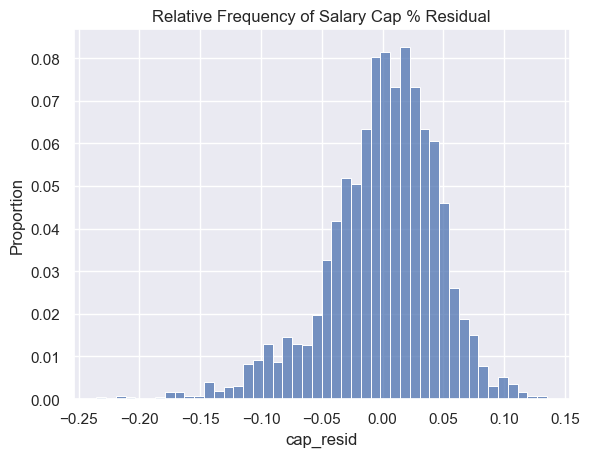

In [58]:
#Create a feature for the residual value
df_dcf['cap_resid'] = df_dcf['primary_pred'] - df_dcf['cap_percent']

#Plot out salary cap percentage residual via histogram
sns.histplot(data=df_dcf, x='cap_resid', stat='proportion').set(title='Relative Frequency of Salary Cap % Residual')

My intuition on the distribution shape was correct here, and most of the residuals are +/-5%, which is a good sign. I’ll now transport the outputs of the primary factor’s regression and use them to build out the DCF model.

In [59]:
#Capture the results of the regression
results = cap_1

#Get the summary as a string
summary_str = results.summary().as_text()

#Write the summary string to a text file
with open('regression_summary.txt', 'w') as file:
    file.write(summary_str)

#Add the individual components of the regression to better format inside Excel
params = results.params
conf_int = results.conf_int()
t_values = results.tvalues
p_values = results.pvalues

#Create a DataFrame with the new components
summary_df = pd.DataFrame({
    'coef': params,
    'lower_ci': conf_int[0],
    'upper_ci': conf_int[1],
    't': t_values,
    'p': p_values
})

#Write the DataFrame to Excel
summary_df.to_excel('regression_summary.xlsx')


After creating an initial DCF model, I realized I’d need some base rates for usage and minutes per game. I’ll create these base rates below based on a player being a star asset and a player’s age.

In [60]:
#Group players by star asset status and view metrics related to the average
prime_group = df_dcf.groupby(['star_asset'])
print(prime_group[['USG', 'MPG']].mean())
print(prime_group[['USG', 'MPG']].median())

                  USG        MPG
star_asset                      
No          18.081235  19.812285
Yes         29.158407  38.358753
             USG        MPG
star_asset                 
No          17.5  18.968750
Yes         29.5  38.545455


In [61]:
#Group players by age and view metrics related to the average
age_group = df_dcf.groupby(['Age'])
print(age_group[['USG', 'MPG']].mean())
print(age_group[['USG', 'MPG']].median())

           USG        MPG
Age                      
18   22.800000   2.000000
19   19.664286  15.508917
20   19.827419  17.904233
21   19.284956  19.439273
22   18.865263  17.387975
23   19.586256  19.149486
24   18.907234  19.278656
25   19.244545  22.805143
26   19.529717  22.713411
27   19.634211  23.536096
28   19.107895  22.953139
29   18.821429  22.934014
30   17.359394  22.245678
31   17.757432  20.030423
32   17.425000  20.209786
33   17.401087  20.490192
34   14.535937  18.161000
35   16.107407  17.109185
36   14.117241  14.678284
37   14.668421  15.521664
38   16.778571  10.040118
39   14.300000  16.458333
40   15.550000  18.750000
       USG        MPG
Age                  
18   22.80   2.000000
19   17.70  14.500000
20   19.25  17.250000
21   18.10  17.333333
22   18.05  16.230392
23   18.90  16.500000
24   17.70  18.333333
25   18.60  22.000000
26   19.15  23.500000
27   19.00  25.825000
28   18.10  24.208333
29   18.55  23.289916
30   16.80  22.700000
31   17.20  20.15000

I have everything needed to build out a DCF model covering a player’s career for up to 20 years, and you can download it from my GitHub repository (labeled “NBA DCF model”). The model’s output is the projected salary cap percentage, so having a view of the growth of the NBA salary cap for the near future is essential. I also softened my stance on a player being a “star asset,” allowing for a “Maybe” option for special cases.

After further review, the most important takeaway from this model is not a player’s intrinsic value but a player’s salary relative to their current contract. Since player contracts tend to be 3-6 years, this timeframe is the most important to evaluate. I compared the projected salary to the actual salary, creating a “Value Ratio.” Similar to how I use DCF models today to ensure I’m not investing in a grossly overvalued company, I view the Value Ratio similarly since General Managers also have to pay players the “market rate” based on a peer comparables-based approach. This fact leads to a small number of “undervalued” contracts in the NBA from an intrinsic value perspective. Early testing tends to show that the best way to find “value” is by drafting rookies who can contribute to the offensive end of the court or signing secondary/tertiary playmaking players who are in their prime.

Like my conclusion from Part 1, a GM must also avoid older players as much as possible, as they tend to have the worst contracts. I didn’t realize how bad Damian Lillard’s contract was until this exercise.

# Part 3 - Separating "Alpha" from "Beta" in Win Production

In investing, the goal is always to find “alpha” or invest in a way that does better than an expected rate of return based on the risks being taken. Those risks must be quantified, typically with a linear regression with different features representing the common ways investors approach the stock market today. For example, buying cheap companies (based on a valuation multiple) and having high profit margins are two common ways to approach investing that can be quantified. These features are known as “beta” or “common factors” in the investment world and can help set an initial return expectation for a stock or an entire portfolio. Create a portfolio that creates “alpha” on top of the expected returns from the “beta,” and you have found success in the stock market.

I will utilize the same thinking to understand what drives win production for a player with hybrid machine learning. I will find the initial expected win percentage based on two different sets of “common factors” with linear regression. I will then use ensemble-based machine learning models to predict the “alpha.” The first set of “common factors” I will analyze the first set of “common factors” based on all the different categorical features I created.

Also, more on hybrid machine learning can be found in the following link:
https://jpt.spe.org/hybrid-machine-learning-explained-nontechnical-terms

In [62]:
#Set up the linear regression equations for win percentage with categorical features
wins_cat = 'win_percent ~ C(Pos) + C(rotation_status) + C(def_liab) + C(off_liab) + C(def_asset) + C(off_asset) + C(star_asset)'

#Fit the regression inputs to win percentage and show the results
wins_1 = smf.ols(formula=wins_cat, data=df_dcf).fit()
wins_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            win_percent   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.575
Method:                 Least Squares   F-statistic:                     313.5
Date:                Sun, 12 Nov 2023   Prob (F-statistic):               0.00
Time:                        12:20:37   Log-Likelihood:                 2697.4
No. Observations:                2543   AIC:                            -5371.
Df Residuals:                    2531   BIC:                            -5301.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.0368      0.005      7.514      0.000       0.027       0.046
C(Pos)[T.PF]                     -0.0169      0.005     -3.176      0.002      -0.027      -0.006
C(Pos)[T.PG]                     -0.0405      0.005     -7.517      0.000      -0.051      -0.030
C(Pos)[T.SF]                     -0.0328      0.006     -5.957      0.000      -0.044      -0.022
C(Pos)[T.SG]                     -0.0450      0.005     -8.580      0.000      -0.055      -0.035
C(rotation_status)[T.bench]       0.1540      0.008     19.513      0.000       0.139       0.169
C(rotation_status)[T.starter]     0.1568      0.007     21.051      0.000       0.142       0.171
C(def_liab)[T.Yes]               -0.0747      0.005    -14.936      0.000      -0.085      -0.065
C(off_liab)[T.Yes]               -0.0962      0.006    -15.817      0.000      -0.108      -0.084
C(def_asset)[T.Yes]               0.0452      0.005      8.827      0.000       0.035       0.055
C(off_asset)[T.Yes]               0.0504      0.007      7.702      0.000       0.038       0.063
C(star_asset)[T.Yes]              0.0374      0.009      4.158      0.000       0.020       0.055
==============================================================================
Omnibus:                      649.246   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8972.855
Skew:                          -0.815   Prob(JB):                         0.00
Kurtosis:                      12.057   Cond. No.                         10.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It’s no surprise that rotation status is the most critical feature, as it’s hard to produce wins when a player can’t get on the court. My “minimize the weakness” theory also continues to hold up, as the offensive and defensive liability features are the second most impactful. I will now use linear regression to make the initial predictions.

In [63]:
#Create initial predictions
df_dcf['wins_primary_cat'] = wins_1.predict(df_dcf)

#Compare the descriptive statistics
df_dcf[['wins_primary_cat', 'win_percent']].describe()

,wins_primary_cat,win_percent
count,2543.000000,2543.000000
mean,0.091290,0.091290
std,0.097811,0.128792
min,-0.025137,-0.836923
25%,0.003987,0.010000
50%,0.073900,0.080000
75%,0.145832,0.173846
max,0.326554,0.970769


The initial linear regression is good at capturing observations around the mean/median but struggles with observations in the tails. I’ll create a feature to grasp the difference between actual and estimated win percentages, also known as the residual, to see the distribution of outcomes. 

[Text(0.5, 1.0, 'Relative Frequency of Win Percent Residual')]

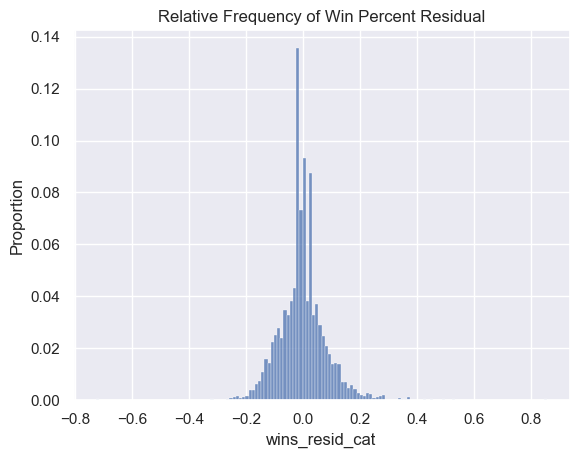

In [64]:
#Create new feature to capture the residual
df_dcf['wins_resid_cat'] = df_dcf['wins_primary_cat'] - df_dcf['win_percent']

#Plot out the residual via histogram
sns.histplot(data=df_dcf, x='wins_resid_cat', stat='proportion').set(title='Relative Frequency of Win Percent Residual')

Although there are plenty of observations near zero, there are also enough observations with large differences that warrant another model. I will set up the machine learning model with the residual being the target feature and utilize cross-validation, given the smaller sample size. Although I prefer the ensemble-based models (Gradient Boosting and Random Forest), I will test several models (including another linear regression) to ensure my preferences are the best choice based on the absolute mean error. Lastly, I will perform a similar scaler function here, just like I utilize z-scores to standardize the input features in Part 1.

In [65]:
#Identify target and input features
Y_c = df_dcf['wins_resid_cat']
X_c = df_dcf[['Age','TS', 'Three_PAr', 'FTr', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'USG', 'MPG', 'def_add', 'AST/TOV', 'TOV_per_USG', 'Three_Pt_to_TS', 'FT_to_TS']]

#Standardize the input features and create a new dataframe with these features
scaler = StandardScaler().fit(X_c)
StandardisedX_c = pd.DataFrame(scaler.fit_transform(X_c))

#Identify test size and seed number
test_size = 0.3
seed = 7

#Create training and testing datasets
X_train, X_test, Y_train, Y_test = train_test_split(StandardisedX_c, Y_c, test_size=test_size, random_state=seed)

#Choose number of folds for cross-validation and scoring method
num_folds = 4
scoring ='neg_mean_absolute_error'

#Create list of all of the models to evaluate
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

#Create empty lists for the testing results and names of models
results = []
names = []

#Create user function to view the scoring results of the cross validation for each model
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    #converted mean abosolute error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.056675 (0.001918)
LASSO: 0.057862 (0.001893)
KNN: 0.051397 (0.001211)
GBR: 0.044280 (0.000916)
RFR: 0.043219 (0.000594)
ETR: 0.042615 (0.000596)


The Extra Trees model (which is similar to Random Forest) provided the best score with the lowest range. I’ll confirm this with a visualization.

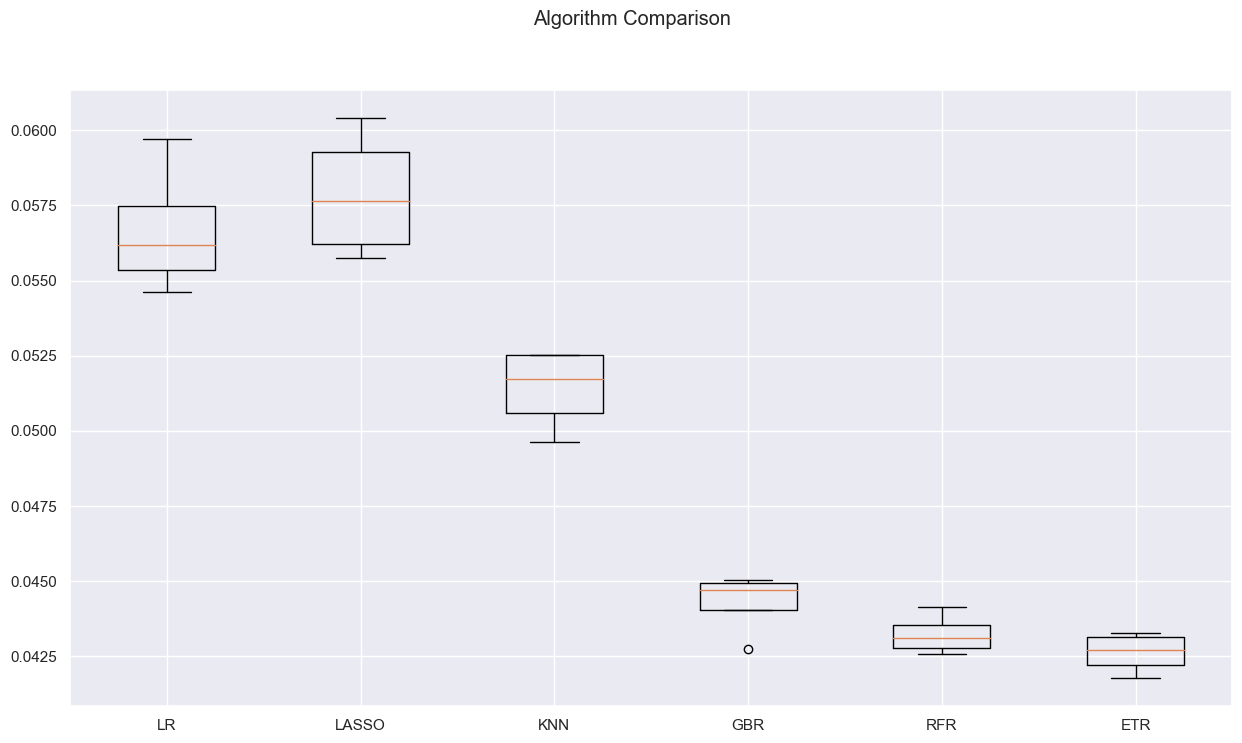

In [66]:
#Compare algorithms with a boxplot
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

Since the Extra Trees model is the best performer, I’ll see if I can optimize the results further based on the number of estimators (or trees) using a grid search.

In [67]:
#Grid search for the best number of estimators for the Extra Trees model
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = ExtraTreesRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.042315 using {'n_estimators': 400}
-0.042767 (0.000340) with: {'n_estimators': 50}
-0.042633 (0.000396) with: {'n_estimators': 100}
-0.042605 (0.000459) with: {'n_estimators': 150}
-0.042492 (0.000490) with: {'n_estimators': 200}
-0.042403 (0.000540) with: {'n_estimators': 250}
-0.042379 (0.000563) with: {'n_estimators': 300}
-0.042347 (0.000544) with: {'n_estimators': 350}
-0.042315 (0.000507) with: {'n_estimators': 400}


I will now fit the Extra Trees model with 400 trees to the training data. I will also discover which features are the most important for finding the residual value. I know the true shooting percentage will still be significant, but I’m wondering how important it is relative to other input features.

[0.02631849 0.22088203 0.02540469 0.03040793 0.044637   0.03020531
 0.0315246  0.04026311 0.0415464  0.03391057 0.07875773 0.07191276
 0.04707273 0.0510072  0.05009565 0.07773265 0.04820652 0.05011463]


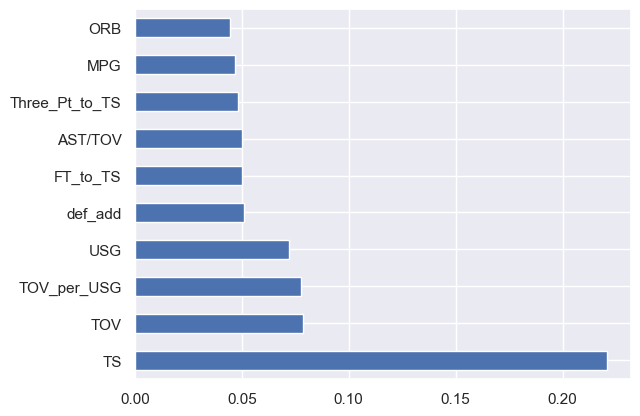

In [68]:
#Use Extra Trees model to fit the training data
model = ExtraTreesRegressor(n_estimators=400) 
model.fit(X_train, Y_train)

#Use inbuilt class feature_importances of tree based regressors
print(model.feature_importances_) 

#Plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_c.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The true shooting percentage is the most critical feature, but the different expressions of turnovers are a close second. In fact, all of the risk-adjusted features I created made the top 10 list of most important features, while the assist rate did not. I will save this model for the testing dataset later in Part 3.

In [69]:
#Save the model to disk
filename = 'wins_cat_model.sav'
dump(model, open(filename, 'wb'))

The second set of “common factors” is based on John Oliver’s four-factor model explaining wins at the team level. The four factors are the effective field goal percentage, the offensive rebounding rate, the turnover rate, and the free throw rate. Given that I’ve used the true shooting percentage feature to this point, I’ll use it here instead of effective field goal percentage. 

More on the four-factor model can be found on the following link: https://statathlon.com/four-factors-basketball-success/

In [70]:
#Set up the linear regression equations for win percentage with four key factors
wins_4f = 'win_percent ~ TS + TOV + ORB + FTr'

#Fit the regression inputs to win percentage and show the results
wins_2 = smf.ols(formula=wins_4f, data=df_dcf).fit()
wins_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            win_percent   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     344.6
Date:                Sun, 12 Nov 2023   Prob (F-statistic):          3.73e-237
Time:                        12:22:49   Log-Likelihood:                 2155.7
No. Observations:                2543   AIC:                            -4301.
Df Residuals:                    2538   BIC:                            -4272.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1951      0.009    -20.772      0.000      -0.214      -0.177
TS             0.5451      0.017     32.479      0.000       0.512       0.578
TOV           -0.0023      0.000     -7.846      0.000      -0.003      -0.002
ORB            0.0038      0.000      8.122      0.000       0.003       0.005
FTr            0.0614      0.010      6.245      0.000       0.042       0.081
==============================================================================
Omnibus:                      207.547   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              671.980
Skew:                          -0.390   Prob(JB):                    1.21e-146
Kurtosis:                       5.394   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Given the higher AIC/BIC, I expect the initial set of predictions not to fit as well as the categorical features used for the first hybrid model. I’ll check if I’m correct by creating the initial predictions.

In [71]:
#Create the initial predictions
df_dcf['wins_primary_4f'] = wins_2.predict(df_dcf)

#View the descriptive statistics
df_dcf[['wins_primary_4f', 'win_percent']].describe()

,wins_primary_4f,win_percent
count,2543.000000,2543.000000
mean,0.091290,0.091290
std,0.076408,0.128792
min,-0.148335,-0.836923
25%,0.052926,0.010000
50%,0.097541,0.080000
75%,0.138789,0.173846
max,0.314267,0.970769


My view is correct, as there is a larger difference in mean and median values, although this model does better in the tails. I’ll confirm this with a histogram. I’m now curious about how correlated the initial predictions for the two sets of “common factors” are. Ideally, they would be uncorrelated.

In [72]:
#View the correlation of the initial predictions
df_dcf[['wins_primary_4f', 'wins_primary_cat']].corr()

,wins_primary_4f,wins_primary_cat
wins_primary_4f,1.000000,0.441993
wins_primary_cat,0.441993,1.000000


The correlation is higher than I would like, but there is still value in having the two models make predictions. I will now create the win percentage residual values and view the distribution via a histogram.

[Text(0.5, 1.0, 'Relative Frequency of Win Percent Residual for 4-Factor Model')]

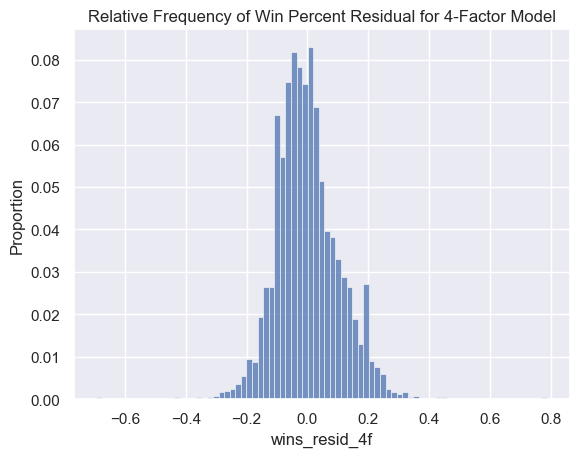

In [73]:
#Create the residual values
df_dcf['wins_resid_4f'] = df_dcf['wins_primary_4f'] - df_dcf['win_percent']

#Plot out the residual via histogram
sns.histplot(data=df_dcf, x='wins_resid_4f', stat='proportion').set(title='Relative Frequency of Win Percent Residual for 4-Factor Model')

Compared to the first model, there are fewer residual values near zero and more positive residual values. I will now run the same process for finding the model with the lowest mean absolute error (MAE) for estimating the residual values. I will also note that this model has fewer features, probably leading to a higher MAE than the first model.

In [74]:
##Identify target and input features
Y_4f = df_dcf['wins_resid_4f']
X_4f = df_dcf[['Age', 'Three_PAr', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'USG', 'MPG', 'def_add', 'AST/TOV', 'TOV_per_USG', 'Three_Pt_to_TS', 'FT_to_TS']]

#Standardize the input features and create a new dataframe with these features
scaler = StandardScaler().fit(X_4f)
StandardisedX_4f = pd.DataFrame(scaler.fit_transform(X_4f))

#Create training and testing datasets
X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(StandardisedX_4f, Y_4f, test_size=test_size, random_state=seed)

#Create list of all of the models to evaluate
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

#Create empty lists for the testing results and names of models
results = []
names = []

#Create user function to view the scoring results of the cross validation for each model
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    #converted mean abosolute error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train_2, Y_train_2, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.069298 (0.001530)
LASSO: 0.079797 (0.001056)
KNN: 0.070223 (0.002073)
GBR: 0.063166 (0.001261)
RFR: 0.062916 (0.001738)
ETR: 0.063108 (0.001306)


The Gradient Boosting model provided the best score with the lowest range. I’ll confirm this with a visualization.

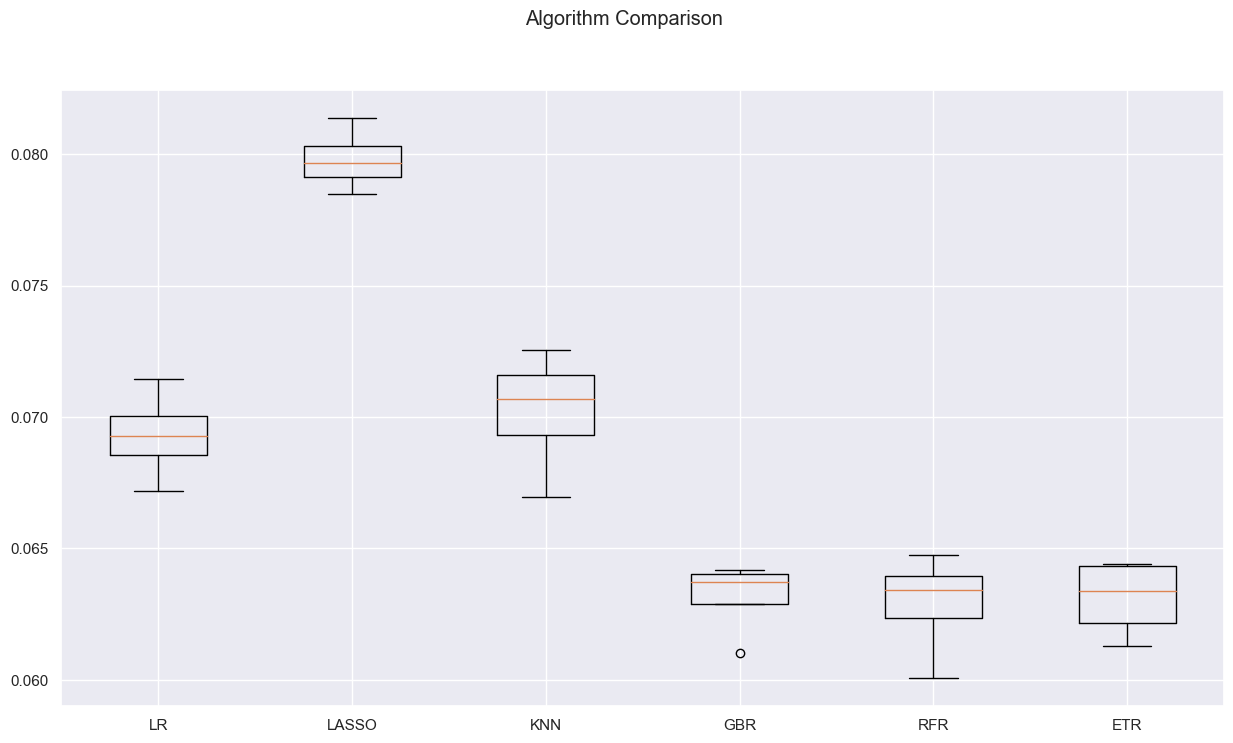

In [75]:
#Compare algorithms with a boxplot
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

The visualization makes the case that a Random Forest model could also work here. However, I’ll still use the Gradient Boosting model based on a lower standard deviation and to have diversification in model approaches. I’ll see if I can optimize this model further based on the number of estimators.

In [76]:
#Grid search for the best number of estimators for the Gradient Boosting model
param_grid = {'n_estimators': [50,100,150,200,250,300,350,400]}
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_2, Y_train_2)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.062033 using {'n_estimators': 250}
-0.064995 (0.001182) with: {'n_estimators': 50}
-0.063109 (0.001099) with: {'n_estimators': 100}
-0.062134 (0.000703) with: {'n_estimators': 150}
-0.062128 (0.000663) with: {'n_estimators': 200}
-0.062033 (0.000695) with: {'n_estimators': 250}
-0.062165 (0.000613) with: {'n_estimators': 300}
-0.062107 (0.000548) with: {'n_estimators': 350}
-0.062251 (0.000599) with: {'n_estimators': 400}


The influence of the Sharpe Ratio is playing a role in my thinking here, as although the 250 estimator model has the best MAE, the 350 estimator model comes close with 80% of the standard deviation. I’ll choose the 350 estimator Gradient Boosting model to estimate the four-factor approach's residual values.

[0.02751504 0.05966536 0.06585511 0.08029387 0.03704511 0.05878034
 0.04706696 0.0857683  0.11234498 0.08809195 0.20924721 0.05622392
 0.05023033 0.02187152]


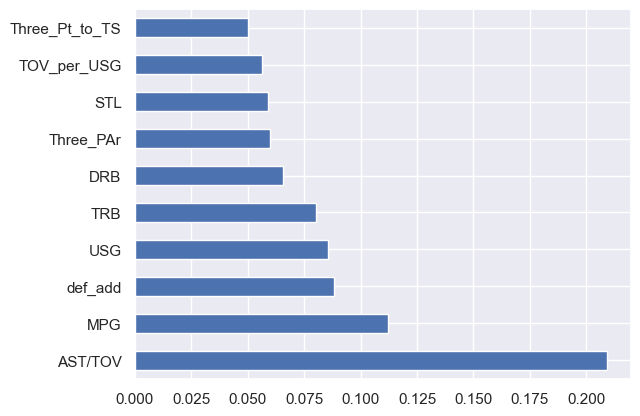

In [77]:
##Use Gradient Boosting model to fit the training data
model_2 = GradientBoostingRegressor(n_estimators=350) 
model_2.fit(X_train_2, Y_train_2)

#Use inbuilt class feature_importances of tree based regressors
print(model_2.feature_importances_) 

#Plot graph of feature importances for better visualization
feat_importances = pd.Series(model_2.feature_importances_, index=X_4f.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

The assist-to-turnover ratio is the most critical factor in this model, reminding me that the assist rate in isolation is not good enough to judge a player. I’ll also save this model.

In [78]:
#Save the model to disk
filename_2 = 'wins_4f_model.sav'
dump(model_2, open(filename_2, 'wb'))

I’ll now use both models to predict the testing dataset, starting with the categorical-based model.

In [79]:
#Load the first model from disk
loaded_model = load(open(filename, 'rb'))

#Estimate accuracy on validation set
predictions = loaded_model.predict(X_test)
result = mean_absolute_error(Y_test, predictions)
print(result)

0.04021977509205945


The MAE is similar to the training dataset, which is a good sign. I’ll now do the same for the four-factor-based model.

In [80]:
#Load the second model from disk
loaded_model_2 = load(open(filename_2, 'rb'))

#Estimate accuracy on validation set
predictions_2 = loaded_model_2.predict(X_test_2)
result_2 = mean_absolute_error(Y_test_2, predictions_2)
print(result_2)

0.060900102917532555


The MAE is also similar to the training dataset. My final test is to see how correlated the residual value predictions are between the two approaches. 

In [81]:
#View the correlation of the residual predictions
print(np.corrcoef(predictions,predictions_2))

[[1.         0.30721836]
 [0.30721836 1.        ]]


The correlations are lower for the residual values than for the initial predictions, which is an excellent sign! Both models can help predict a player’s win contribution, and combining them would increase prediction accuracy given the lower correlation. 

From a GM’s perspective, the best way to build a team is to find players with a higher predicted wins produced percentage than the salary cap percentage while not overpaying for that player from a conventional perspective of what drives a player’s salary. I touched on all these components in this project, so I hope my favorite NBA teams (LA Lakers and Houston Rockets) utilize these measures.